# Processo Seletivo Vagas - Cientista de Dados Sr.

Essa solução foi desenvolvida por Lucas Souza Costa como parte do processo de seleção para a vaga de Cientista de Dados na empresa VAGAS.com  
Para maiores informações de contato: 

<p style="text-align: center;">
    <a href="https://www.linkedin.com/in/lucas-costa-0b964a164/"><img src="images/linkedin.png" alt="Linkedin" style="margin-right: 3%;"></a>
    <a href="https://github.com/lucalsc"><img src="images/github.png" alt="GitHub" style="margin-right: 2%;"></a>
    <a href="https://www.kaggle.com/clockstar"><img src="images/kaggle.png" alt="Linkedin" style="margin-right: 3%;" ></a>
</p>

### Objetivo
Modelar uma máquina de aprendizado que seja capaz de prever quais candidatos serão aprovados no processo seletivo.


### Métrica
Neste desafio você deverá utilizar a métrica F1-Score

### Estrutura
Esse projeto está estruturado seguindo as etapas do fluxograma abaixo  
<br>
<p style = "text-align: center;">
    <img src="images/diagram1.png" alt="Diagrama">
</p>

## Ingestão dos dados

In [328]:
#Imports/Styles

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, train_test_split
from skopt import dummy_minimize
from imblearn.over_sampling import RandomOverSampler
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from lightgbm import LGBMClassifier
from mlxtend.classifier import StackingClassifier
from imblearn.over_sampling import ADASYN
import scikitplot as skplt

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

In [329]:
#Dados em formato pickle

df_train = pd.read_pickle('dataset/base_treinamento_testes.pkl')
df_test = pd.read_pickle('dataset/base_submission.pkl')
#Garantindo ordenação
df_test['ID'] = range(len(df_test))
#Verificando
print(f'Treino possui {df_train.shape[0]} linhas e {df_train.shape[1]} colunas.')
print(f'Teste possui {df_test.shape[0]} linhas e {df_test.shape[1]} colunas.\n')

df_train.head()

Treino possui 25699 linhas e 18 colunas.
Teste possui 26579 linhas e 18 colunas.



,codigo_vaga,ultimo_salario_candidato,ultimo_cargo_candidato,area_interesse_candidato,nivel_candidato,formacao_candidato,cidade_candidato,nivel_ingles_candidato,nivel_espanhol_candidato,mediana_teste_ingles_candidato,mediana_teste_espanhol_candidato,mediana_teste_logica_candidato,mediana_teste_outros_candidato,cargo_vaga,nivel_vaga,formacao_vaga,cidade_vaga,aprovado_vaga
4146,-5433147389500583028,0.0,INDUSTRIAL TRAINEE,ENGENHARIA QUIMICA,JUNIOR/TRAINEE,POS-GRADUACAO NO NIVEL ESPECIALIZACAO,SALVADOR,2.0,1.0,6.450,0.000,6.25,7.00,PROGRAMA TRAINEE,JUNIOR/TRAINEE,FORMACAO SUPERIOR (CURSANDO),None,0
4147,-5433147389500583028,1500.0,DESENVOLVIMENTO ENGENHEIRO PRO,ADMINISTRACAO DE EMPRESAS,JUNIOR/TRAINEE,FORMACAO SUPERIOR COMPLETA,SAO PAULO,4.0,1.0,8.000,0.000,7.99,8.20,PROGRAMA TRAINEE,JUNIOR/TRAINEE,FORMACAO SUPERIOR (CURSANDO),None,0
4148,-5433147389500583028,2050.0,CLIENTE ESTAGIO QUALIDADE,ENGENHARIA DE PRODUCAO,ESTAGIO,FORMACAO SUPERIOR COMPLETA,ARUJA,2.0,0.0,3.875,0.000,5.33,5.40,PROGRAMA TRAINEE,JUNIOR/TRAINEE,FORMACAO SUPERIOR (CURSANDO),None,0
4149,-5433147389500583028,0.0,CONTA EXECUTIVO PARCERIA,MARKETING,JUNIOR/TRAINEE,FORMACAO SUPERIOR COMPLETA,SAO PAULO,3.0,0.0,7.250,0.000,7.99,6.25,PROGRAMA TRAINEE,JUNIOR/TRAINEE,FORMACAO SUPERIOR (CURSANDO),None,0
4150,-5433147389500583028,1890.0,CICLO PDCA,MARKETING,AUXILIAR/OPERACIONAL,POS-GRADUACAO NO NIVEL ESPECIALIZACAO,SAO PAULO,3.0,4.0,5.250,6.375,6.65,7.00,PROGRAMA TRAINEE,JUNIOR/TRAINEE,FORMACAO SUPERIOR (CURSANDO),None,0


## Data Cleaning

### codigo_vaga
Em uma primeira análise fiquei tentado a ignorar a coluna codigo_vaga... "se trata apenas de um identificador" pensei, porém, é possível através dela notar um detalhe que nos poupa muita dor de cabeça futuramente. Vamos ver isso em código.

In [330]:
#Primeiro de tudo, vamos avaliar a média de valores para cada codigo_vaga.
df_train.groupby('codigo_vaga').mean()

,ultimo_salario_candidato,nivel_ingles_candidato,nivel_espanhol_candidato,mediana_teste_ingles_candidato,mediana_teste_espanhol_candidato,mediana_teste_logica_candidato,mediana_teste_outros_candidato,aprovado_vaga
codigo_vaga,,,,,,,,
-8665149857608157082,2746.445820,3.303406,1.504644,5.889958,1.441254,5.421083,5.942096,0.136223
-8121008623955203509,2506.155039,3.284238,1.288114,6.003648,1.349887,6.303608,6.286980,0.073643
-7433230746669201352,2798.852861,3.298365,1.276567,6.088065,1.426124,5.991828,6.587081,0.059946
-5433147389500583028,1912.164854,3.284812,1.302701,5.862659,1.261675,6.001040,6.391886,0.039635
-4680893303693323076,1950.325534,3.277711,1.153032,6.063418,1.105006,6.418933,6.524372,0.076345
-3218332895185976716,2340.045421,3.028571,1.088645,5.405054,1.080733,5.907915,6.501344,0.084249
-3139734604785841859,2823.845845,3.582440,1.280161,6.192708,1.263678,6.165475,6.568887,0.106568
-2894132490890953032,9067.025862,0.293103,0.224138,0.084591,0.038793,0.054483,6.698707,0.125000
-1872122770023579723,69.321207,0.150843,0.163265,0.063784,0.066770,0.123456,2.411579,0.185448


O que isso nos revela exatamente? Em primeiro lugar revela que apesar de possuir 25000 linhas (treino) as candidaturas são para apenas 20 vagas. Em segundo lugar, ao observar a coluna "ultimo_salario_candidato" é possível notar que diversos valores giram em torno de 1500~3000 reais, porém existem valores anormais como é o caso da vaga com ID "8670946023719118796" possuindo salário médio de 40.000 reais e notas de testes baixíssimas... vamos averiguar o motivo dessa discrepância.

In [331]:
df_train.loc[df_train.codigo_vaga == 8670946023719118796, ['ultimo_salario_candidato', 'ultimo_cargo_candidato', 'cidade_candidato']].head(10)

,ultimo_salario_candidato,ultimo_cargo_candidato,cidade_candidato
39207,0.0,APLICACIONES INGENIERO JEFE MA,BOGOTA
39208,0.0,AREA DESARROLLO EN PROCESSO PR,BOGOTA
39209,0.0,ANALYST TEST,BOGOTA
39210,0.0,AT CHEMICAL ENGINEER LABORATOR,BOGOTA
39211,0.0,ADMINISTRATIVO ASSISTENTE COME,BARRANQUILLA
39212,0.0,ADMINISTRATIVO,CALI
39213,0.0,AUXILIAR CAMBIO,BUCARAMANGA
39214,0.0,ENGINEER PROFESSOR,BUCARAMANGA
39215,0.0,ASSOCIATE ENGINEER,FACATATIVA
39216,0.0,ANALISTA SERVICO TRANSACCIONAL,BOGOTA


Selecionei apenas as colunas necessárias para extrair o seguinte: Essa vaga não é (ou pelo menos, a grande maioria dos aplicantes) destinada ao brasil. Isso traz algumas implicações, como por exemplo, o fato de que os salários registrados por participantes não-brasileiros são exorbitantes (Possivelmente devido a sua moeda) e possuem um número muito elevado de 0's.

In [332]:
#Salários
print(f'Para a vaga com codigo 8670946023719118796, {np.round((len(df_train.loc[(df_train.codigo_vaga == 8670946023719118796) & (df_train.ultimo_salario_candidato == 0),:]) / len(df_train.loc[df_train.codigo_vaga == 8670946023719118796]))*100, 2)}% são valores 0. \n')
print(f'A média salarial para a vaga com código 8670946023719118796 é:', np.round(df_train.loc[df_train.codigo_vaga == 8670946023719118796, 'ultimo_salario_candidato' ].mean(),2), '\n')
df_train.loc[(df_train.codigo_vaga == 8670946023719118796) & (df_train.ultimo_salario_candidato > 0), ['ultimo_salario_candidato', 'ultimo_cargo_candidato', 'cidade_candidato']].head()

Para a vaga com codigo 8670946023719118796, 95.45% são valores 0. 

A média salarial para a vaga com código 8670946023719118796 é: 40447.72 



,ultimo_salario_candidato,ultimo_cargo_candidato,cidade_candidato
39252,41000.0,ENGENHARIA JOVEM MECANICO PARC,SARRIA
39267,700.0,ENGINEER MAINTENANCE,CARTAGENA
39270,3000000.0,COMERCIAL GESTION PROFISSIONAL,BOGOTA
39280,1220000.0,PRODUCCION TRAINEE,MEDELLIN
39305,10000.0,ENGENHEIRO PROJETO TRAINEE,SAO PAULO


Avaliando outra vaga que apresenta comportamento estranho, possuindo código 4005443819117183679.

In [333]:
#Salários
print(f'Para a vaga com codigo -1872122770023579723, {np.round((len(df_train.loc[(df_train.codigo_vaga == -1872122770023579723) & (df_train.ultimo_salario_candidato == 0),:]) / len(df_train.loc[df_train.codigo_vaga == -1872122770023579723]))*100, 2)}% são valores 0. \n')
print(f'A média salarial para a vaga com código -1872122770023579723 é:', np.round(df_train.loc[df_train.codigo_vaga == -1872122770023579723, 'ultimo_salario_candidato' ].mean(),2), '\n')
df_train.loc[(df_train.codigo_vaga == -1872122770023579723) & (df_train.ultimo_salario_candidato > 0), ['ultimo_salario_candidato', 'ultimo_cargo_candidato', 'cidade_candidato']].head()

Para a vaga com codigo -1872122770023579723, 97.52% são valores 0. 

A média salarial para a vaga com código -1872122770023579723 é: 69.32 



,ultimo_salario_candidato,ultimo_cargo_candidato,cidade_candidato
50647,14000.0,ANALYST CHAIN FOREIGN SUPPLY T,BUENOS AIRES
50768,1300.0,COMERCIAL PRODUTO,BUENOS AIRES
50772,4000.0,ADMINISTRADOR PROJECT,BERAZATEGUI
50779,5500.0,GERENTE MARKETING OPERACAO,GUARATINGUETA
50783,400.0,ALMACEN PRATICANTE PROFISSIONA,LIMA


Para finalizar, vamos observar o comportamento de uma vaga nos "conformes".

In [334]:
#Salários
print(f'Para a vaga com codigo -8121008623955203509, {np.round((len(df_train.loc[(df_train.codigo_vaga == -8121008623955203509) & (df_train.ultimo_salario_candidato == 0),:]) / len(df_train.loc[df_train.codigo_vaga == -8121008623955203509]))*100, 2)}% são valores 0. \n')
print(f'A média salarial para a vaga com código -8121008623955203509 é:', np.round(df_train.loc[df_train.codigo_vaga == -8121008623955203509, 'ultimo_salario_candidato' ].mean(),2), '\n')
df_train.loc[(df_train.codigo_vaga == -8121008623955203509) & (df_train.ultimo_salario_candidato > 0), ['ultimo_salario_candidato', 'ultimo_cargo_candidato', 'cidade_candidato']].head()

Para a vaga com codigo -8121008623955203509, 24.81% são valores 0. 

A média salarial para a vaga com código -8121008623955203509 é: 2506.16 



,ultimo_salario_candidato,ultimo_cargo_candidato,cidade_candidato
47106,3000.0,AUDITOR COORDENADOR,SAO PAULO
47107,8200.0,GERENTE PROJETO,CURITIBA
47108,2300.0,ANALISTA HUMANOS RECURSOS,SALVADOR
47109,1500.0,ASSISTENTE DIGITAL MARKETING,SAO PAULO
47110,3800.0,ARQUITETO PROJETO,BELO HORIZONTE


In [335]:
#Salários
print(f'Para a vaga com codigo -8665149857608157082, {np.round((len(df_train.loc[(df_train.codigo_vaga == -8665149857608157082) & (df_train.ultimo_salario_candidato == 0),:]) / len(df_train.loc[df_train.codigo_vaga == -8665149857608157082]))*100, 2)}% são valores 0. \n')
print(f'A média salarial para a vaga com código -8665149857608157082 é:', np.round(df_train.loc[df_train.codigo_vaga == -8665149857608157082, 'ultimo_salario_candidato' ].mean(),2), '\n')
df_train.loc[(df_train.codigo_vaga == -8665149857608157082) & (df_train.ultimo_salario_candidato > 0), ['ultimo_salario_candidato', 'ultimo_cargo_candidato', 'cidade_candidato']].head()

Para a vaga com codigo -8665149857608157082, 20.43% são valores 0. 

A média salarial para a vaga com código -8665149857608157082 é: 2746.45 



,ultimo_salario_candidato,ultimo_cargo_candidato,cidade_candidato
39800,9500.0,AUDITOR CORPORATE,GUARULHOS
39801,3500.0,COMERCIAL REPRESENTANTE,SAO PAULO
39802,3000.0,CAIXA,RIO DE JANEIRO
39803,7380.0,CONSULTOR MARKETING,SAO PAULO
39804,4200.0,ADMINISTRATIVO ANALISTA,SAO PAULO


Comparando esses 4 exemplos acima podemos chegar a seguinte conclusão: Brasileiros acabam preenchendo melhor e mais frequentemente quais são seus salários anteriores, além disso, esses valores ficam mais alinhados a nossa realidade devido a moeda ser o Real. Outro ponto que gostaria de destacar é a discrepância entre as notas obtidas em testes (A causa disso é a grande quantidade de zeros obtidas nesses testes), a melhor forma de observar isso graficamente.

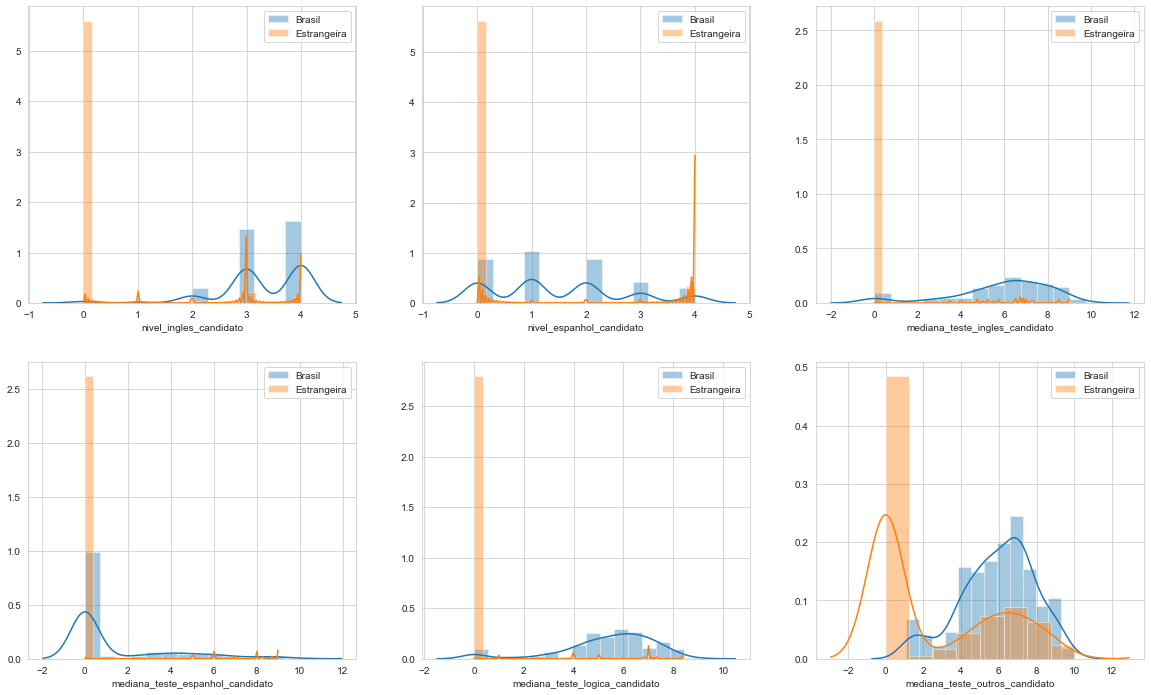

In [336]:
#As vagas utilizadas aqui são essas:
# Vaga "brasileira" - -8665149857608157082
# Vaga "estrangeira" - 8670946023719118796


to_plot = ['nivel_ingles_candidato', 'nivel_espanhol_candidato', 'mediana_teste_ingles_candidato', 'mediana_teste_espanhol_candidato', 
           'mediana_teste_logica_candidato', 'mediana_teste_outros_candidato']


fig, ax = plt.subplots(2, 3, figsize = (20,12))

k = 0
for i in range(0,2):
    for j in range(0,3):
        try:
            sns.distplot(df_train.loc[df_train.codigo_vaga == -8665149857608157082, to_plot[k]], ax = ax[i,j])
            sns.distplot(df_train.loc[df_train.codigo_vaga == 8670946023719118796, to_plot[k]], ax = ax[i,j])
            ax[i,j].legend(['Brasil', 'Estrangeira'])
            k += 1
        except:
            continue
        
        


O que procuro exemplificar até então é que essas vagas apresentam realidades distintas, por exemplo, em um modelo de Regressão Logística as notas de vagas brasileiras (que possuem em geral valores muito superiores) teriam peso muito maior do que aquelas que possuem majoritariamente candidatos estrangeiros. Minha proposta inicial é realizar o ensemble de dois modelos distintos para melhor abordar essa diferença, mas isso dependerá do restante da análise.

### Estimando a nacionalidade da vaga.
Precisamos avaliar se existe uma massa de dados homogênea para nossa modelagem. Essa etapa pode ser feita de uma maneira "primitiva" aonde cada vaga é analisada individualmente, sendo outra possibilidade a utilização de uma regra customizada para automatizar a classificação. Para esse desafio, os dados "brasileiros" e "estrangeiros" possuem uma discrepância grande que permite traçar um divisor linear entre essas duas categorias.

In [337]:
#Dados feitos a mão
#Treino
# -8665149857608157082 - Brasil
# -8121008623955203509 - Brasil
# -7433230746669201352 - Brasil
# -5433147389500583028 - Brasil
# -4680893303693323076 - Brasil
# -3218332895185976716 - Brasil
# -3139734604785841859 - Brasil
# -2894132490890953032 - Estrangeiro
# -1872122770023579723 - Estrangeiro
# -408011488522086617 -  Estrangeiro
# -328337796252815598 - Brasil
# 3432259187290165962 - Brasil
# 3773628003473435874 - Brasil
# 4005443819117183679 - Estrangeiro
# 5837574494153107582 - Brasil
# 7173759003647469929 - Brasil
# 8194206283447659751 - Estrangeiro
# 8670946023719118796 - Estrangeiro
# 8869708662086095038 - Brasil
# 9034887193305818436 - Brasil

#Teste
# -8851622128430865144 - Brasil
# -6387918047679571035 - Brasil
# -5432475023076753918 - Brasil
# -4540071236086954297 - Estrangeiro
# -3926712961740574529 - Estrangeiro
# 1167184937340811227 - Brasil
# 1221578433373216729 - Brasil


#Automatizando

nacio_train = pd.DataFrame({'codigo_vaga': df_train.groupby('codigo_vaga').mean().index,
                           'Nacionalidade': [0 if x[1]['nivel_ingles_candidato'] < 1.0 else 1 for x in df_train.groupby('codigo_vaga').mean().iterrows()]})

nacio_test = pd.DataFrame({'codigo_vaga': df_test.groupby('codigo_vaga').mean().index,
                           'Nacionalidade': [0 if x[1]['nivel_ingles_candidato'] < 1.0 else 1 for x in df_test.groupby('codigo_vaga').mean().iterrows()]})


#Verificando
nacio_test


,codigo_vaga,Nacionalidade
0,-8851622128430865144,1
1,-6387918047679571035,1
2,-5432475023076753918,1
3,-4540071236086954297,0
4,-3926712961740574529,0
5,1167184937340811227,1
6,1221578433373216729,1


Ufa! Agora temos definidos em nosso conjunto de dados quais vagas fazem parte do mesmo "universo", tanto para os dados de treino quanto para os dados de teste.

### Situação dos dados
Agora podemos começar nossa limpeza de verdade. Primeiramente, vamos separar os universos que definimos acima.

In [338]:
#Experimental


def most_candidates(x):
    return x.cidade_candidato.value_counts().index[0]

def input_city(df):
    none_city = df.groupby('codigo_vaga')['cidade_vaga'].apply(lambda x: x.isnull().any()).reset_index()
    for vaga, isnull in zip(none_city['codigo_vaga'], none_city['cidade_vaga']):
        if isnull:
            vaga_data = df.loc[df.codigo_vaga == vaga]
            candidato_frequent = most_candidates(vaga_data)
            df.loc[df.codigo_vaga == vaga, 'cidade_vaga'] = candidato_frequent
    return df


df_train = input_city(df_train)
df_test = input_city(df_test)

df_train['igual_cidade'] = [1 if x[1]['cidade_candidato'] == x[1]['cidade_vaga'] else 0 for x in df_train.iterrows()]
df_test['igual_cidade'] = [1 if x[1]['cidade_candidato'] == x[1]['cidade_vaga'] else 0 for x in df_test.iterrows()]


#Arquivo externo com UF's e cidades
df_cidades = pd.read_csv('dataset/cidades.csv')[['Uf', 'Nome']]
df_cidades.head()
import unidecode

#Tirando acentos e colocando em maiusculo
df_cidades['Nome'] = df_cidades.Nome.apply(lambda x: unidecode.unidecode(x))
df_cidades['Nome'] = df_cidades.Nome.apply(lambda x: x.upper())
df_cidades.set_index('Nome', inplace = True)



map_cidades = df_cidades.to_dict()['Uf']

df_train['Uf_candidato'] = df_train.cidade_candidato.map(map_cidades)
df_train['Uf_vaga'] = df_train.cidade_vaga.map(map_cidades)
df_train['igual_uf'] = [1 if x[1]['Uf_candidato'] == x[1]['Uf_vaga'] else 0 for x in df_train.iterrows()]
df_train['Uf_candidato'] = df_train.Uf_candidato.fillna('Nulo')
df_train['Uf_vaga'] = df_train.Uf_vaga.fillna('Nulo')

df_test['Uf_candidato'] = df_test.cidade_candidato.map(map_cidades)
df_test['Uf_vaga'] = df_test.cidade_vaga.map(map_cidades)
df_test['igual_uf'] = [1 if x[1]['Uf_candidato'] == x[1]['Uf_vaga'] else 0 for x in df_test.iterrows()]
df_test['Uf_candidato'] = df_test.Uf_candidato.fillna('Nulo')
df_test['Uf_vaga'] = df_test.Uf_vaga.fillna('Nulo')

In [339]:
df_train.head()

,codigo_vaga,ultimo_salario_candidato,ultimo_cargo_candidato,area_interesse_candidato,nivel_candidato,formacao_candidato,cidade_candidato,nivel_ingles_candidato,nivel_espanhol_candidato,mediana_teste_ingles_candidato,...,mediana_teste_outros_candidato,cargo_vaga,nivel_vaga,formacao_vaga,cidade_vaga,aprovado_vaga,igual_cidade,Uf_candidato,Uf_vaga,igual_uf
4146,-5433147389500583028,0.0,INDUSTRIAL TRAINEE,ENGENHARIA QUIMICA,JUNIOR/TRAINEE,POS-GRADUACAO NO NIVEL ESPECIALIZACAO,SALVADOR,2.0,1.0,6.450,...,7.00,PROGRAMA TRAINEE,JUNIOR/TRAINEE,FORMACAO SUPERIOR (CURSANDO),SAO PAULO,0,0,BA,SP,0
4147,-5433147389500583028,1500.0,DESENVOLVIMENTO ENGENHEIRO PRO,ADMINISTRACAO DE EMPRESAS,JUNIOR/TRAINEE,FORMACAO SUPERIOR COMPLETA,SAO PAULO,4.0,1.0,8.000,...,8.20,PROGRAMA TRAINEE,JUNIOR/TRAINEE,FORMACAO SUPERIOR (CURSANDO),SAO PAULO,0,1,SP,SP,1
4148,-5433147389500583028,2050.0,CLIENTE ESTAGIO QUALIDADE,ENGENHARIA DE PRODUCAO,ESTAGIO,FORMACAO SUPERIOR COMPLETA,ARUJA,2.0,0.0,3.875,...,5.40,PROGRAMA TRAINEE,JUNIOR/TRAINEE,FORMACAO SUPERIOR (CURSANDO),SAO PAULO,0,0,SP,SP,1
4149,-5433147389500583028,0.0,CONTA EXECUTIVO PARCERIA,MARKETING,JUNIOR/TRAINEE,FORMACAO SUPERIOR COMPLETA,SAO PAULO,3.0,0.0,7.250,...,6.25,PROGRAMA TRAINEE,JUNIOR/TRAINEE,FORMACAO SUPERIOR (CURSANDO),SAO PAULO,0,1,SP,SP,1
4150,-5433147389500583028,1890.0,CICLO PDCA,MARKETING,AUXILIAR/OPERACIONAL,POS-GRADUACAO NO NIVEL ESPECIALIZACAO,SAO PAULO,3.0,4.0,5.250,...,7.00,PROGRAMA TRAINEE,JUNIOR/TRAINEE,FORMACAO SUPERIOR (CURSANDO),SAO PAULO,0,1,SP,SP,1


In [340]:
df_test.columns

Index(['codigo_vaga', 'ultimo_salario_candidato', 'ultimo_cargo_candidato',
       'area_interesse_candidato', 'nivel_candidato', 'formacao_candidato',
       'cidade_candidato', 'nivel_ingles_candidato',
       'nivel_espanhol_candidato', 'mediana_teste_ingles_candidato',
       'mediana_teste_espanhol_candidato', 'mediana_teste_logica_candidato',
       'mediana_teste_outros_candidato', 'cargo_vaga', 'nivel_vaga',
       'formacao_vaga', 'cidade_vaga', 'ID', 'igual_cidade', 'Uf_candidato',
       'Uf_vaga', 'igual_uf'],
      dtype='object')

In [341]:
#Separando df_train
df_train = df_train.merge(nacio_train, how = 'left', on='codigo_vaga')
df_train_br = df_train.loc[df_train.Nacionalidade == 1, :]
df_train_es = df_train.loc[df_train.Nacionalidade == 0, :]

#Separando df_teste
df_test = df_test.merge(nacio_test, how = 'left', on='codigo_vaga')
df_test_br = df_test.loc[df_test.Nacionalidade == 1, :]
df_test_es = df_test.loc[df_test.Nacionalidade == 0, :]

#Verificando:
print(f'Shape df_train_br: {df_train_br.shape}')
print(f'Shape df_train_es: {df_train_es.shape}')
print(f'Shape df_test_br: {df_test_br.shape}')
print(f'Shape df_test_es: {df_test_es.shape}')

Shape df_train_br: (21813, 23)
Shape df_train_es: (3886, 23)
Shape df_test_br: (21320, 23)
Shape df_test_es: (5259, 23)


In [342]:
#Avaliando a situação de nulos

train = [df_train_br, df_train_es]
test = [df_test_br, df_test_es]
labels = ['BR', 'ES']

print(f'Situação de nulas para treino:\n')
for df, label in zip(train, labels):
    print(f'{label}\n')
    print(df.isnull().sum()[df.isnull().sum()>0])
    print('')
    
print(f'Situação de nulas para teste:\n')
for df, label in zip(test, labels):
    print(f'{label}\n')
    print(df.isnull().sum()[df.isnull().sum()>0])
    print('')
    

Situação de nulas para treino:

BR

area_interesse_candidato     259
nivel_candidato              380
cidade_candidato               4
cargo_vaga                  3207
dtype: int64

ES

area_interesse_candidato    3561
nivel_candidato              219
cidade_candidato               2
dtype: int64

Situação de nulas para teste:

BR

area_interesse_candidato      369
nivel_candidato               286
cidade_candidato                4
cargo_vaga                  17529
dtype: int64

ES

area_interesse_candidato    5042
nivel_candidato              385
cidade_candidato               1
dtype: int64



In [343]:
#Avaliando a situação dos valores 0

print(f'Situação de zeros para treino:\n')
for df, label in zip(train, labels):
    print(f'{label}\n')
    print(f'Total de registros: {len(df)}\n')
    print((df == 0).sum()[(df == 0).sum() > 0])
    print('')
    
print(f'Situação de zeros para teste:\n')
for df, label in zip(test, labels):
    print(f'{label}\n')
    print(f'Total de registros: {len(df)}\n')
    print((df == 0).sum()[(df == 0).sum() > 0])
    print('')

Situação de zeros para treino:

BR

Total de registros: 21813

ultimo_salario_candidato             6056
nivel_ingles_candidato                806
nivel_espanhol_candidato             7041
mediana_teste_ingles_candidato       1821
mediana_teste_espanhol_candidato    16655
mediana_teste_logica_candidato       1489
mediana_teste_outros_candidato         71
aprovado_vaga                       20035
igual_cidade                        16236
igual_uf                            10210
dtype: int64

ES

Total de registros: 3886

ultimo_salario_candidato            3698
nivel_ingles_candidato              3601
nivel_espanhol_candidato            3647
mediana_teste_ingles_candidato      3795
mediana_teste_espanhol_candidato    3836
mediana_teste_logica_candidato      3742
mediana_teste_outros_candidato      1678
aprovado_vaga                       3146
igual_cidade                        2770
igual_uf                            3357
Nacionalidade                       3886
dtype: int64

Situação

É possível notar que os valores estrangeiros possuem uma elevada taxa de valores zeros, o que provavelmente será um grande problema em nossa modelagem.

### ultimo_salario_candidato
É possível que alguns registros zerados são provavelmente fruto de problemas no preenchimento das informações, porém alguns registros parecem fazer sentido nesse quesito (Aprendizes, Estágios não remunerados, trainees, etc.). Atualmente possuimos cerca de 10000 registros de treino (BR + ES) que possuem salário anterior como zero, vamos analisar quantos desses casos são advindos de trainees/estágios/aprendizes.

In [344]:
#Função que verifica se as palavras "aprendiz, estagio, etc."

filter_list = ['aprendiz', 'estagio', 'estágio', 'trainee', 'interno', 'internship', 'bolsa', 'nao', 'classificado', 'quick', 'voluntario']

def is_new(row):
    for word in row['ultimo_cargo_candidato'].lower().split():
        if word in filter_list:
            return 1
        else:
            continue
    
    return 0

#Aplicando a função e verificando quantos registros advem dos termos acima. 0 Significa pessoas que não são do grupo estágio/trainee, 1 significa pessoas advindas deste grupo.

#Treino
for df in train:
    df['is_new'] = df.apply(lambda x: is_new(x), axis = 1)
    print(df.loc[df_train.ultimo_salario_candidato == 0].is_new.value_counts())

#Teste
for df in test:
    df['is_new'] = df.apply(lambda x: is_new(x), axis = 1)

0    3477
1    2579
Name: is_new, dtype: int64
0    3368
1     330
Name: is_new, dtype: int64


Dos dados BR, cerca de 2579 salários registrados como 0 são frutos de pessoas que aparentam estar em início de carreira. Vamos tentar diminuir o número de valores zeros aplicando a seguinte regra: Profissionais que possuam nível pleno e salário registrado como zero terão salários imputados com a média de sua profissão. O objetivo é diminuir ao máximo salários zerados para pessoas que ja atuam a um tempo considerável na profissão.

In [345]:
num_vars = ['ultimo_salario_candidato', 'nivel_ingles_candidato', 'nivel_espanhol_candidato', 'mediana_teste_ingles_candidato', 'mediana_teste_espanhol_candidato', 
            'mediana_teste_logica_candidato', 'mediana_teste_outros_candidato']

#Definindo função
def plain_mean(df, row):
    if row['is_new'] == 0:
        if row['nivel_candidato'] in ['JUNIOR/TRAINEE', 'ESTAGIO']:
            return row['ultimo_salario_candidato']
        else:
            #dados filtrados pela profissão
            prof_data = df.loc[df.ultimo_cargo_candidato == row['ultimo_cargo_candidato'], :]
            #Média salarial
            if df.ultimo_cargo_candidato.value_counts()[row['ultimo_cargo_candidato']] == 1:
                return row['ultimo_salario_candidato']
            else:
                mean_salary = prof_data.loc[prof_data.ultimo_salario_candidato != 0, 'ultimo_salario_candidato'].mean()
                return mean_salary
    else:
        return row['ultimo_salario_candidato']
    
#Aplicando a função em treino

for df in train:
    
    new_salaries = df.apply(lambda x: plain_mean(df, x), axis = 1)
    new_salaries = new_salaries.fillna(0)
    df['ultimo_salario_candidato'] = new_salaries

#Aplicando em teste   
for df in test:
    new_salaries = df.apply(lambda x: plain_mean(df, x), axis = 1)
    new_salaries = new_salaries.fillna(0)
    df['ultimo_salario_candidato'] = new_salaries
    
#Verificando em treino
for df in train:
    print((df.loc[:, num_vars] == 0).sum(),'\n')




ultimo_salario_candidato             4721
nivel_ingles_candidato                806
nivel_espanhol_candidato             7041
mediana_teste_ingles_candidato       1821
mediana_teste_espanhol_candidato    16655
mediana_teste_logica_candidato       1489
mediana_teste_outros_candidato         71
dtype: int64 

ultimo_salario_candidato            3550
nivel_ingles_candidato              3601
nivel_espanhol_candidato            3647
mediana_teste_ingles_candidato      3795
mediana_teste_espanhol_candidato    3836
mediana_teste_logica_candidato      3742
mediana_teste_outros_candidato      1678
dtype: int64 



Conseguimos preencher cerca de 1300 registros zerados em treino (BR) e cerca de 120 registros em treino (ES). Para finalizar os trabalhos nessa feature, vamos analisar outliers e criar bins de salários.

In [346]:
#Antes de tudo, analisando o describe da nossa variável.
print('Treino BR:\n')
print(df_train_br.ultimo_salario_candidato.describe())
print('\nTreino ES:\n')
print(df_train_es.ultimo_salario_candidato.describe())

#BR possui alguns valores extremos de salários. Um valor salarial máximo de 40.000 parece razoável.
#Colocando todo salário máximo em 40.000 (Aproximadamente o percentil 99.93 da amostra)
#Porém ,avaliar ES é um pouco mais complicado. Muitos registros passam a casa de 1 milhão e isso pode ser consequência da moeda, então aplicar uma regra de restrição salarial acabaria
#alterando muitos registros. Para ES vamos deixar os dados como estão.

#Alterando os dados de BR
#Treino
df_train_br.loc[df_train_br.ultimo_salario_candidato > 40000, 'ultimo_salario_candidato'] = 40000
#Teste
df_test_br.loc[df_test_br.ultimo_salario_candidato > 40000, 'ultimo_salario_candidato'] = 40000

#Verificando
print('Treino BR após transformação: \n')
print(df_train_br.ultimo_salario_candidato.describe())

Treino BR:

count    2.181300e+04
mean     2.826665e+03
std      4.173626e+04
min      0.000000e+00
25%      8.000000e+02
50%      2.000000e+03
75%      3.425800e+03
max      5.500000e+06
Name: ultimo_salario_candidato, dtype: float64

Treino ES:

count    3.886000e+03
mean     2.779629e+04
std      2.360915e+05
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      3.500000e+06
Name: ultimo_salario_candidato, dtype: float64
Treino BR após transformação: 

count    21813.000000
mean      2288.671954
std       2189.193333
min          0.000000
25%        800.000000
50%       2000.000000
75%       3425.800000
max      40000.000000
Name: ultimo_salario_candidato, dtype: float64


Text(0.5, 1.0, 'Distribuição do ultimo salário (Log1p - Treino BR)')

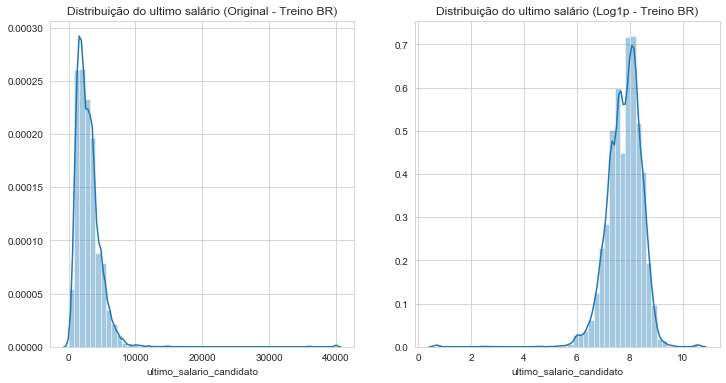

In [347]:
#O resultado da binarização fica muito mais satisfatório com a aplicação de uma transformação logaritmica. Vamos utilizar log1p (Diminuição do skewness dos dados.)
#Apenas avaliando graficamente essa mudança

fig,ax = plt.subplots(1,2,figsize=(12,6))
sns.distplot(df_train_br.loc[df_train_br.ultimo_salario_candidato > 0, 'ultimo_salario_candidato'], ax = ax[0])
sns.distplot(np.log1p(df_train_br.loc[df_train_br.ultimo_salario_candidato > 0, 'ultimo_salario_candidato']), ax = ax[1])
ax[0].set_title('Distribuição do ultimo salário (Original - Treino BR)')
ax[1].set_title('Distribuição do ultimo salário (Log1p - Treino BR)')

Desde o início existia a possibilidade de remover as linhas que possuíssem um valor salarial muito elevado afinal elas estão "quebrando" nossa distribuição, porém, nos dados de teste essa característica também é preservada e para o conjunto de teste abandonar linhas não é uma opção (Todos os registros de teste precisam ser preditos). Apenas para fim de prova, vamos verificar a distribuição de teste

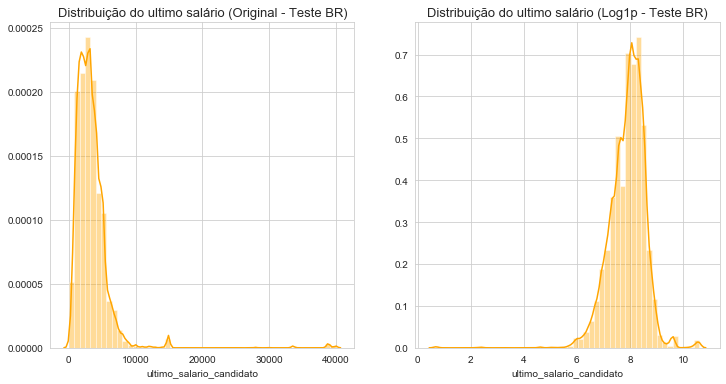

In [348]:
fig,ax = plt.subplots(1,2,figsize=(12,6))
sns.distplot(df_test_br.loc[df_test_br.ultimo_salario_candidato > 0, 'ultimo_salario_candidato'], ax = ax[0], color='orange')
sns.distplot(np.log1p(df_test_br.loc[df_test_br.ultimo_salario_candidato > 0, 'ultimo_salario_candidato']), ax = ax[1], color = 'orange')
ax[0].set_title('Distribuição do ultimo salário (Original - Teste BR)', fontsize = 13)
ax[1].set_title('Distribuição do ultimo salário (Log1p - Teste BR)', fontsize = 13)
plt.show()

In [349]:
#Binarizando
#Salário 0 - Recebe label 0 
#Salário acima de 15000 - Recebe Label 10

#Treino
df_train_br['salary_bin'] = pd.to_numeric(pd.cut(df_train_br.loc[(df_train_br.ultimo_salario_candidato > 0) & (df_train_br.ultimo_salario_candidato < 15000), 'ultimo_salario_candidato'], 9, labels = [1,2,3,4,5,6,7,8,9]))
df_train_br.loc[df_train_br.ultimo_salario_candidato == 0, 'salary_bin'] = 0
df_train_br.loc[df_train_br.ultimo_salario_candidato >= 15000, 'salary_bin'] = 10

#Teste
df_test_br['salary_bin'] = pd.to_numeric(pd.cut(df_test_br.loc[(df_test_br.ultimo_salario_candidato > 0) & (df_test_br.ultimo_salario_candidato < 15000), 'ultimo_salario_candidato'], 9, labels = [1,2,3,4,5,6,7,8,9]))
df_test_br.loc[df_test_br.ultimo_salario_candidato == 0, 'salary_bin'] = 0
df_test_br.loc[df_test_br.ultimo_salario_candidato >= 15000, 'salary_bin'] = 10

In [350]:
#Treino
df_train_br['ingles_bin'] = pd.to_numeric(pd.cut(df_train_br.loc[(df_train_br.mediana_teste_ingles_candidato > 0) & (df_train_br.mediana_teste_ingles_candidato < 9), 'mediana_teste_ingles_candidato'], 5, labels = [1,2,3,4,5]))
df_train_br.loc[df_train_br.mediana_teste_ingles_candidato == 0, 'ingles_bin'] = 0
df_train_br.loc[df_train_br.mediana_teste_ingles_candidato >= 9, 'ingles_bin'] = 6

#Teste
df_test_br['ingles_bin'] = pd.to_numeric(pd.cut(df_test_br.loc[(df_test_br.mediana_teste_ingles_candidato > 0) & (df_test_br.mediana_teste_ingles_candidato < 9), 'mediana_teste_ingles_candidato'], 5, labels = [1,2,3,4,5]))
df_test_br.loc[df_test_br.ingles_bin == 0, 'ingles_bin'] = 0
df_test_br.loc[df_test_br.ingles_bin >= 9, 'ingles_bin'] = 6

In [351]:
#Treino
df_train_br['logica_bin'] = pd.to_numeric(pd.cut(df_train_br.loc[(df_train_br.mediana_teste_logica_candidato > 0) & (df_train_br.mediana_teste_logica_candidato < 9), 'mediana_teste_logica_candidato'], 5, labels = [1,2,3,4,5]))
df_train_br.loc[df_train_br.mediana_teste_logica_candidato == 0, 'logica_bin'] = 0
df_train_br.loc[df_train_br.mediana_teste_logica_candidato >= 9, 'logica_bin'] = 6

#Teste
df_test_br['logica_bin'] = pd.to_numeric(pd.cut(df_test_br.loc[(df_test_br.mediana_teste_logica_candidato > 0) & (df_test_br.mediana_teste_logica_candidato < 9), 'mediana_teste_logica_candidato'], 5, labels = [1,2,3,4,5]))
df_test_br.loc[df_test_br.logica_bin == 0, 'logica_bin'] = 0
df_test_br.loc[df_test_br.logica_bin >= 9, 'logica_bin'] = 6

In [352]:
#Treino
df_train_br['total_score'] = (df_train_br.mediana_teste_ingles_candidato + df_train_br.mediana_teste_espanhol_candidato + df_train_br.mediana_teste_logica_candidato + df_train_br.mediana_teste_outros_candidato) / 4
df_test_br['total_score'] = (df_test_br.mediana_teste_ingles_candidato + df_test_br.mediana_teste_espanhol_candidato + df_test_br.mediana_teste_logica_candidato + df_test_br.mediana_teste_outros_candidato) / 4
#Teste
df_train_es['total_score'] = (df_train_es.mediana_teste_ingles_candidato + df_train_es.mediana_teste_espanhol_candidato + df_train_es.mediana_teste_logica_candidato + df_train_es.mediana_teste_outros_candidato) / 4
df_test_es['total_score'] = (df_test_es.mediana_teste_ingles_candidato + df_test_es.mediana_teste_espanhol_candidato + df_test_es.mediana_teste_logica_candidato + df_test_es.mediana_teste_outros_candidato) / 4
#df_train_br['total_score'] = (df_train_br.mediana_teste_ingles_candidato + df_train_br.mediana_teste_espanhol_candidato + df_train_br.mediana_teste_logica_candidato + df_train_br.mediana_outros_logica_candidato) / 4

### area_interesse_candidato / nivel_candidato / cidade_candidato / cargo_vaga
Para essas features, vamos substituir os valores nulos com "Indefinido".

In [353]:
#Treino
for df in train:
    df['area_interesse_candidato'] = df.area_interesse_candidato.fillna('Indefinido')

    #Limpando nivel_candidato
    #Imputando "None" com "Indefinido"
    df['nivel_candidato'] = df.nivel_candidato.fillna('Indefinido')

    #Limpando cidade_candidato
    df['cidade_candidato'] = df.cidade_candidato.fillna('Indefinido')

    #Limpando cargo_vaga
    #Imputando "None" com "Indefinido"
    df['cargo_vaga'] = df.cargo_vaga.fillna('Indefinido')

#Test
for df in test:
    df['area_interesse_candidato'] = df.area_interesse_candidato.fillna('Indefinido')

    #Limpando nivel_candidato
    #Imputando "None" com "Indefinido"
    df['nivel_candidato'] = df.nivel_candidato.fillna('Indefinido')

    #Limpando cidade_candidato
    df['cidade_candidato'] = df.cidade_candidato.fillna('Indefinido')

    #Limpando cargo_vaga
    #Imputando "None" com "Indefinido"
    df['cargo_vaga'] = df.cargo_vaga.fillna('Indefinido')
    
#Verificando
print(f'Situação de nulas para treino:\n')
for df, label in zip(train, labels):
    print(f'{label}\n')
    print(df.isnull().sum()[df.isnull().sum()>0])
    print('')
    
print(f'Situação de nulas para teste:\n')
for df, label in zip(test, labels):
    print(f'{label}\n')
    print(df.isnull().sum()[df.isnull().sum()>0])
    print('')
    

Situação de nulas para treino:

BR

Series([], dtype: int64)

ES

Series([], dtype: int64)

Situação de nulas para teste:

BR

ingles_bin    2672
logica_bin    2248
dtype: int64

ES

Series([], dtype: int64)



### cidade_vaga / nivel_vaga
A coluna nivel_vaga só possuei registros de 'JUNIOR/TRAINEE' tanto para treino quanto para teste, logo a mesma será abandonada. Antes de abandonar, confirmarei essa afirmação.  
A coluna "cidade_vaga" será abandonada por possuir uma elevada quantidade de valores nulos, tanto para os dados de treino quanto para os dados de teste.

In [354]:
#Confirmando os valores constantes de 'JUNIOR/TRAINEE' para nivel_vaga
for label, df in zip(labels, train):
    print(f'Treino {label}:')
    print(df.nivel_vaga.unique(), '\n')
    
for label, df in zip(labels, test):
    print(f'Teste {label}:')
    print(df.nivel_vaga.unique(), '\n')

Treino BR:
['JUNIOR/TRAINEE'] 

Treino ES:
['JUNIOR/TRAINEE'] 

Teste BR:
['JUNIOR/TRAINEE'] 

Teste ES:
['JUNIOR/TRAINEE'] 



In [355]:
#Abandonando as variáveis
#Treino
for df in train:
    df.drop(['nivel_vaga'], axis = 1, inplace = True)
    
#Teste
for df in test:
    df.drop(['nivel_vaga'], axis = 1, inplace = True)

### cargo_vaga
Outro problema diz respeito a feature "cargo_vaga". Existe uma discrepância de valores para as bases de treino e teste, conferindo abaixo é possível nota que o unico registro presente nos dois dataframes é "PROGRAMA TRAINEE" e os dados de teste possuem uma quantidade menor de valores unicos. Para evitar qualquer tipo de viés, não vamos inserir essa feature em nosso modelo em um primeiro momento.

In [356]:
for df, label in zip(train, labels):
    print(f'Treino {label}:')
    print(df.cargo_vaga.unique(), '\n')
    
for df, label in zip(test, labels):
    print(f'Test {label}:')
    print(df.cargo_vaga.unique(), '\n')

#Removendo
#Treino
for df in train:
    df.drop('cargo_vaga',axis=1, inplace = True)
    
#Teste
for df in test:
    df.drop('cargo_vaga',axis=1, inplace = True)
    

Treino BR:
['PROGRAMA TRAINEE' 'Indefinido' 'COMERCIAL' 'GERENTE LOJA SUPERMERCADO'
 'INTERNACIONAL TRAINEE'] 

Treino ES:
['PROGRAMMER' 'INTERNACIONAL TRAINEE' 'TELECOMUNICACAO TRAINEE'
 'PROGRAMA TRAINEE' 'TRAINEE'] 

Test BR:
['Indefinido' 'PROGRAMA TRAINEE'] 

Test ES:
['COORDENADOR PROGRAMA' 'CORPORATIVO TRAINEE'] 



### area_interesse_candidato
A ultima feature que iremos trabalhar é a área de interesse do candidato, os dados de treino possuem 116 possibilidades de interesse e os dados de teste possuem 118. A abordagem utilizada será agregar a área de interesse do candidato em grupos de interesse que possuem similaridades entre sí.

In [357]:
#Definindo os grupos

#Administração, negócios e serviços
adm_neg = ['administracao', 'recursos', 'marketing', 'turismo', 'logistica', 'comercio', 'gestao', 'relacoes', 'compras', 'comunicacao', 'atend.', 'turismo', 'auditoria', 
           'financas', 'contabilidade', 'controladoria', 'compras', 'economia', 'fiscal', 'bancos']

#Artes
artes = ['cinema', 'design', 'artes', 'moda', 'musica', 'cultural', 'arquitetura/urbanismo', 'comunicacao']

#Ciências biologicas e terra
biologicas = ['agronomia', 'biologicas', 'ecologia/meio', 'geologia', 'meteorologia', 'oceanografia', 'zootecnia', 'zoologia', 'veterinaria']

#Engenharia e produção
engenharia = ['engenharia', 'mineracao', 'manutencao', 'producao/fabricacao', 'petrolifera', 'industrial']

#Ciências exatas
exatas = ['fisica', 'informatica/t.i.', 'internet', 'matematica/estatistica', 'quimica']

#Saúde
saude = ['biomedicina', 'enfermagem', 'farmacia', 'medicina/hospitalar', 'nutricao', 'odontologia', 'psicologia']

#Comunicação
comunic = ['jornalismo', 'propaganda', 'publicas', 'radioalismo', 'telecomunicacoes']

In [358]:
#Criando função que agrupa

def group_interests(row):
    for keyword in row['area_interesse_candidato'].lower().split():
        
        if keyword in adm_neg:
            return 'Administracao'
        elif keyword in artes:
            return 'Arte'
        elif keyword in biologicas:
            return 'Biologicas'
        elif keyword in engenharia:
            return 'Engenharia'
        elif keyword in exatas:
            return 'Exatas'
        elif keyword in saude:
            return 'Saude'
        elif keyword in comunic:
            return 'Comunicacao'
        else:
            continue
            
    return 'Outro'

#Aplicando a função e agrupando interesses
for df in train:
    df['grupo_interesse'] = df.apply(lambda x: group_interests(x), axis = 1)

for df in test:
    df['grupo_interesse'] = df.apply(lambda x: group_interests(x), axis = 1)

#Verificando
df_train_br.head()

,codigo_vaga,ultimo_salario_candidato,ultimo_cargo_candidato,area_interesse_candidato,nivel_candidato,formacao_candidato,cidade_candidato,nivel_ingles_candidato,nivel_espanhol_candidato,mediana_teste_ingles_candidato,...,Uf_candidato,Uf_vaga,igual_uf,Nacionalidade,is_new,salary_bin,ingles_bin,logica_bin,total_score,grupo_interesse
0,-5433147389500583028,0.0,INDUSTRIAL TRAINEE,ENGENHARIA QUIMICA,JUNIOR/TRAINEE,POS-GRADUACAO NO NIVEL ESPECIALIZACAO,SALVADOR,2.0,1.0,6.450,...,BA,SP,0,1,1,0.0,4.0,4.0,4.92500,Engenharia
1,-5433147389500583028,1500.0,DESENVOLVIMENTO ENGENHEIRO PRO,ADMINISTRACAO DE EMPRESAS,JUNIOR/TRAINEE,FORMACAO SUPERIOR COMPLETA,SAO PAULO,4.0,1.0,8.000,...,SP,SP,1,1,0,1.0,5.0,5.0,6.04750,Administracao
2,-5433147389500583028,2050.0,CLIENTE ESTAGIO QUALIDADE,ENGENHARIA DE PRODUCAO,ESTAGIO,FORMACAO SUPERIOR COMPLETA,ARUJA,2.0,0.0,3.875,...,SP,SP,1,1,1,2.0,2.0,3.0,3.65125,Engenharia
3,-5433147389500583028,0.0,CONTA EXECUTIVO PARCERIA,MARKETING,JUNIOR/TRAINEE,FORMACAO SUPERIOR COMPLETA,SAO PAULO,3.0,0.0,7.250,...,SP,SP,1,1,0,0.0,4.0,5.0,5.37250,Administracao
4,-5433147389500583028,1890.0,CICLO PDCA,MARKETING,AUXILIAR/OPERACIONAL,POS-GRADUACAO NO NIVEL ESPECIALIZACAO,SAO PAULO,3.0,4.0,5.250,...,SP,SP,1,1,0,2.0,3.0,4.0,6.31875,Administracao


## EDA
Antes de continuar o processo de conformação dos dados, vamos compreender algumas características deles

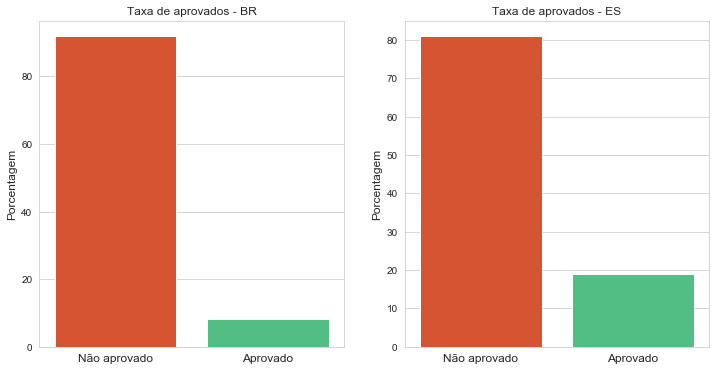

In [359]:
#Distribuição de aprovados/não aprovados.
fig, ax = plt.subplots(1, 2, figsize = (12,6))

k = 0
for df in train:
    approved_data = (df.aprovado_vaga.value_counts() / len(df)) * 100
    sns.barplot(x = approved_data.index, y = approved_data, ax = ax[k], palette=['#f04516', '#3fd183'])
    ax[k].set_title(f'Taxa de aprovados - {labels[k]}')
    ax[k].set_xticklabels(['Não aprovado', 'Aprovado'], fontsize = 12)
    ax[k].set_ylabel('Porcentagem', fontsize = 12)
    k += 1


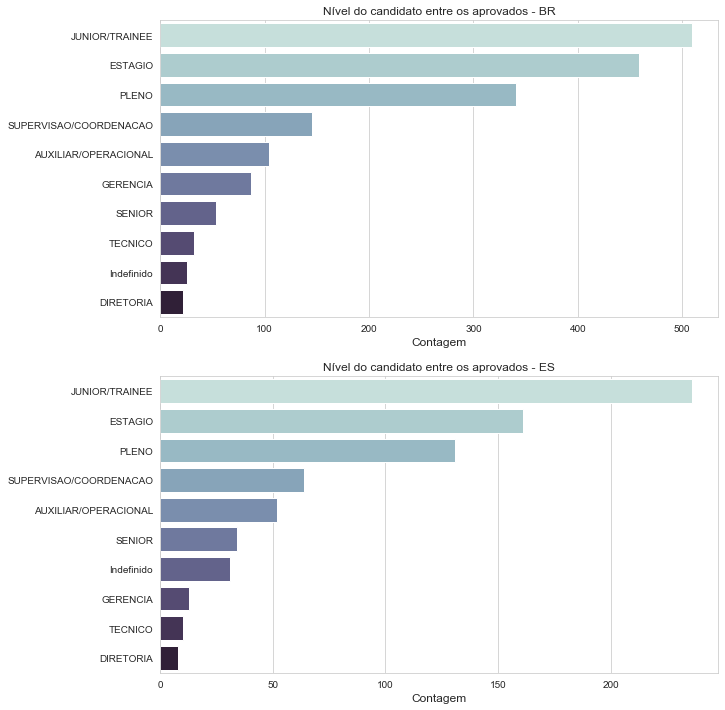

In [360]:
#Entre os candidatos aprovados, quais os níveis mais predominantes?
fig, ax = plt.subplots(2, 1, figsize = (10,12))

k = 0
for df in train:
    #Data
    approved_data = df.loc[df.aprovado_vaga == 1, 'nivel_candidato'].value_counts()
    #Plot
    sns.barplot(x = approved_data, y = approved_data.index, ax = ax[k], palette=sns.cubehelix_palette(10, start=.5, rot=-.45))
    ax[k].set_title(f'Nível do candidato entre os aprovados - {labels[k]}')
    ax[k].set_xlabel('Contagem', fontsize = 12)
    k+=1

A plotagem a seguir apenas diz respeito aos dados de vagas brasileiras


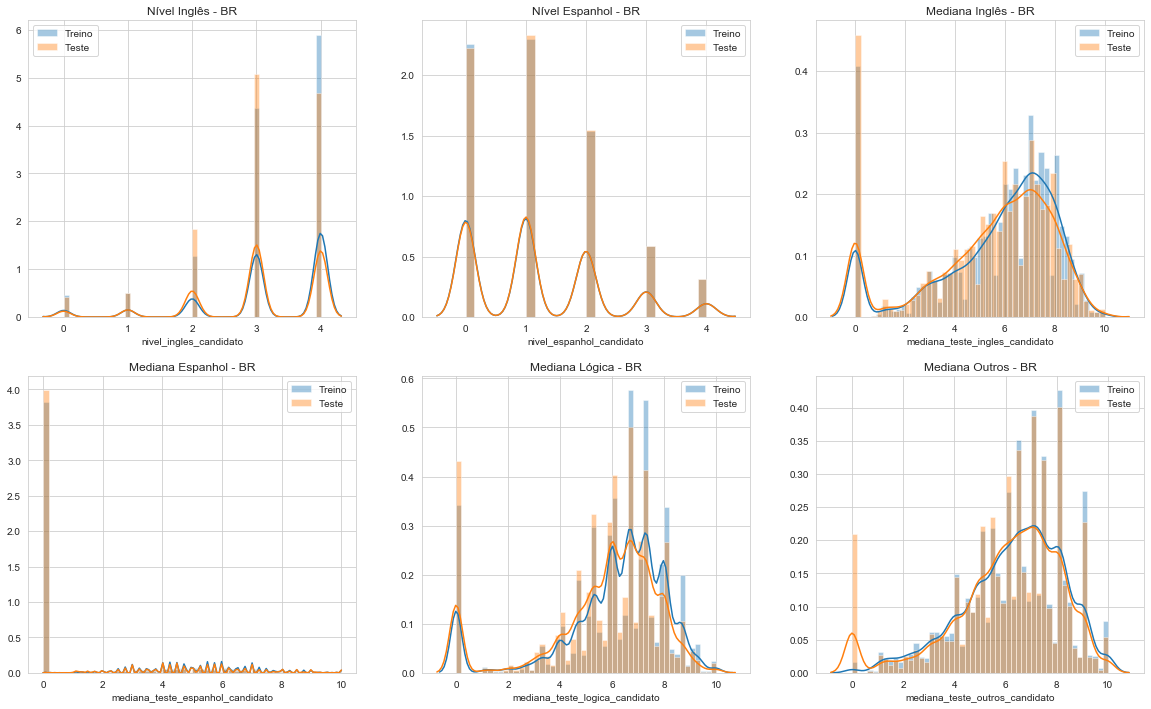

In [361]:
#Avaliando a distribuição entre os dados de treino e teste para os resultados dos testes

#Features
to_plot = ['nivel_ingles_candidato', 'nivel_espanhol_candidato', 'mediana_teste_ingles_candidato', 'mediana_teste_espanhol_candidato', 
           'mediana_teste_logica_candidato', 'mediana_teste_outros_candidato']

labels_plot = ['Nível Inglês', 'Nível Espanhol', 'Mediana Inglês', 'Mediana Espanhol', 'Mediana Lógica', 'Mediana Outros']

#Plot
fig, ax = plt.subplots(2, 3, figsize=(20,12))

k = 0
print('A plotagem a seguir apenas diz respeito aos dados de vagas brasileiras')
for i in range(0,2):
    for j in range(0,3):
        try:
            sns.distplot(df_train_br[to_plot[k]], ax = ax[i,j])
            sns.distplot(df_test_br[to_plot[k]], ax = ax[i,j])
            ax[i,j].legend(['Treino', 'Teste'])
            ax[i,j].set_title(f'{labels_plot[k]} - BR')
            
            k += 1
        except:
            continue
            

Ótimo, as distribuições de treino e teste são bastante similares. É interessante notar como o domínio da lingua espanhola é menos frequente do que o domínio da lingua inglesa (Por exigência do mercado, eu imagino?)

A plotagem a seguir apenas diz respeito aos dados de vagas estrangeiras


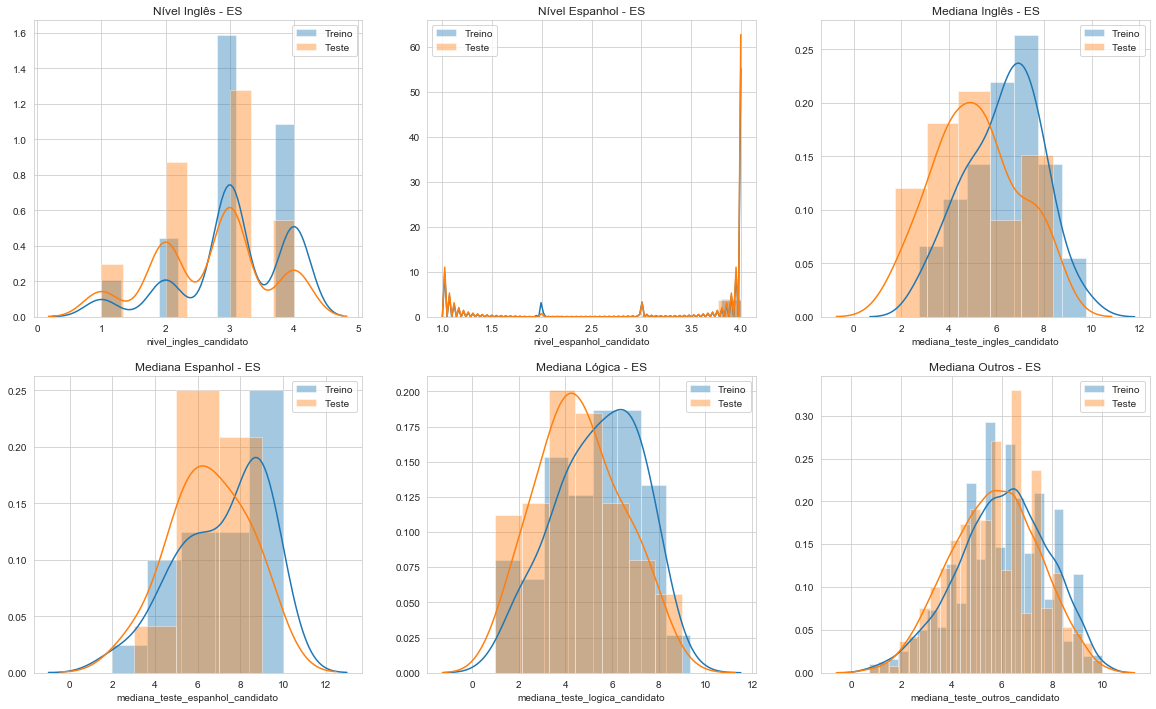

In [362]:
#Plot
fig, ax = plt.subplots(2, 3, figsize=(20,12))

k = 0
print('A plotagem a seguir apenas diz respeito aos dados de vagas estrangeiras')
for i in range(0,2):
    for j in range(0,3):
        try:
            sns.distplot(df_train_es.loc[df_train_es[to_plot[k]] > 0, to_plot[k]], ax = ax[i,j])
            sns.distplot(df_test_es.loc[df_test_es[to_plot[k]] > 0, to_plot[k]], ax = ax[i,j])
            ax[i,j].legend(['Treino', 'Teste'])
            ax[i,j].set_title(f'{labels_plot[k]} - ES')
            
            k += 1
        except:
            continue

A grande questão e motivo para separar os dados de vagas "brasileiras" e "estrangeiras" se da no fato de que vagas estrangeiras possuem um número relativo muito grande de 0's. Adaptei o plot acima para mostrar apenas valores que são maiores do que zero, e é possível notar que esses valores (provavelmente devido a baixa quantidade de dados) são mais instáveis quando comparamos treino e teste (Por exemplo: a mediana do teste de lógica para treino tem pico de frequência em 7, enquanto os dados de teste possuem pico de frequência em 5. O mesmo acontece para a mediana do teste de espanhol).

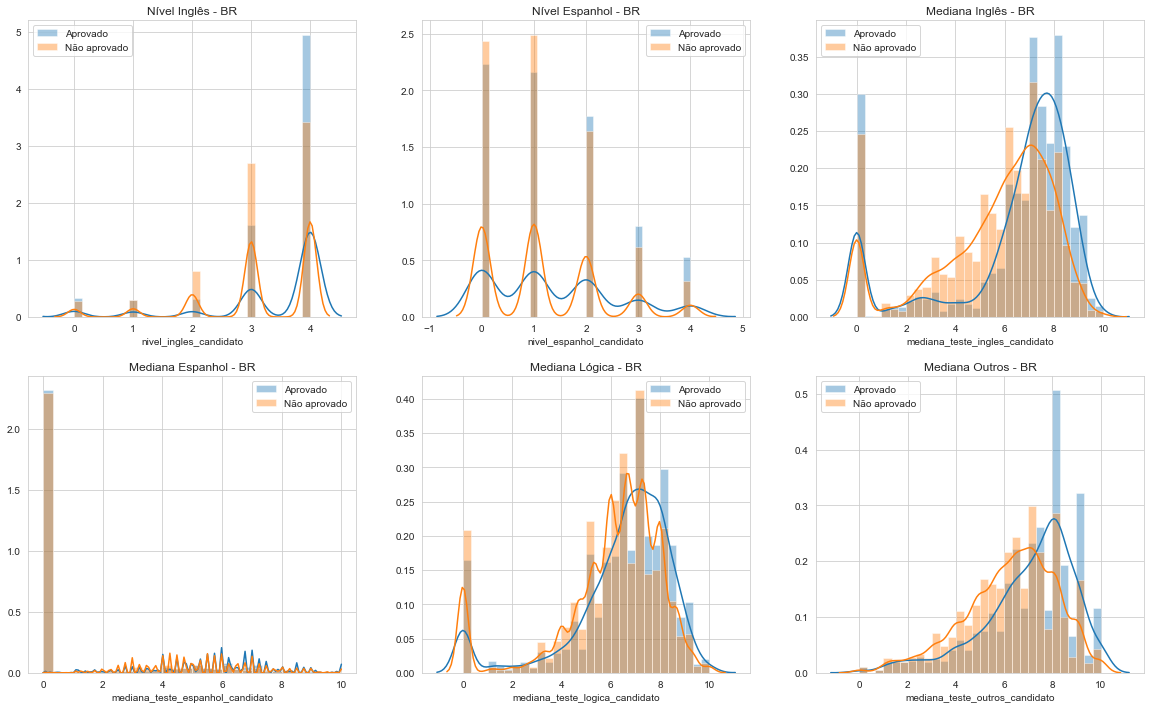

In [363]:
#Vamos observar se existem tendências entre pessoas aprovadas e não aprovadas.

fig, ax = plt.subplots(2, 3, figsize=(20,12))

k = 0

for i in range(0,2):
    for j in range(0,3):
        try:
            sns.distplot(df_train_br.loc[df_train_br.aprovado_vaga == 1, to_plot[k]], ax = ax[i,j], bins = 30)
            sns.distplot(df_train_br.loc[df_train_br.aprovado_vaga == 0, to_plot[k]], ax = ax[i,j], bins = 30)
            ax[i,j].legend(['Aprovado', 'Não aprovado'])
            ax[i,j].set_title(f'{labels_plot[k]} - BR')
            
            k += 1
        except:
            continue

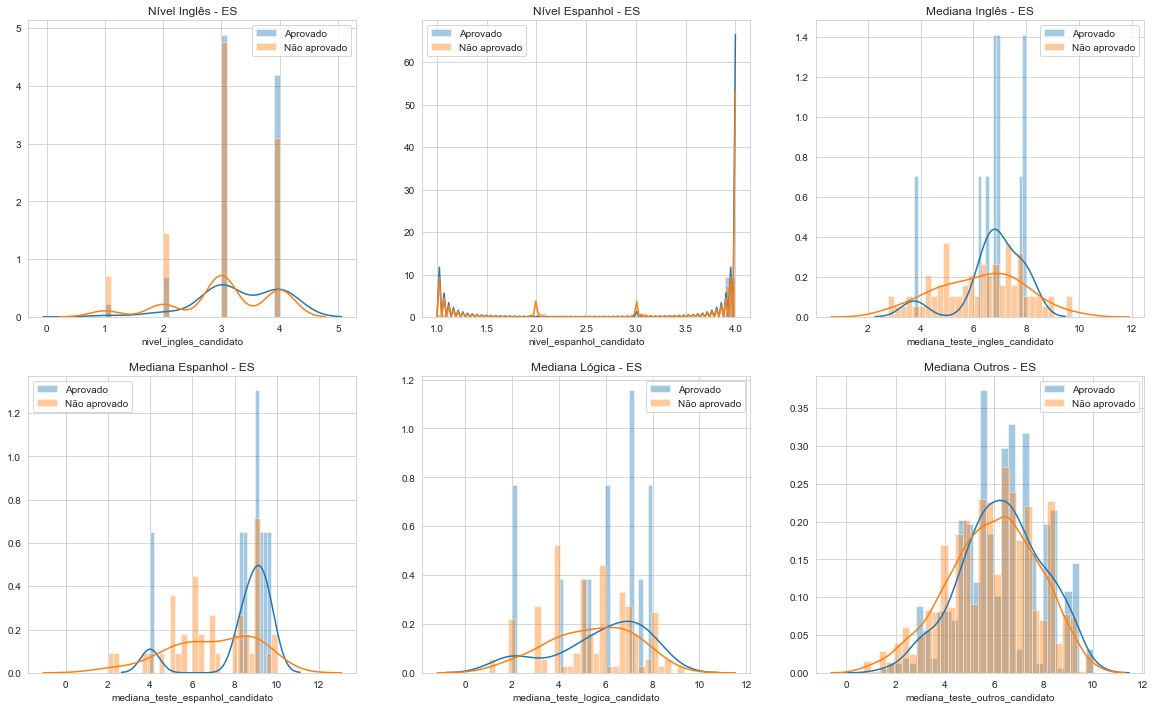

In [364]:
fig, ax = plt.subplots(2, 3, figsize=(20,12))

k = 0

for i in range(0,2):
    for j in range(0,3):
        try:
            sns.distplot(df_train_es.loc[(df_train_es.aprovado_vaga == 1) & (df_train_es[to_plot[k]] > 0), to_plot[k]], ax = ax[i,j], bins = 30)
            sns.distplot(df_train_es.loc[(df_train_es.aprovado_vaga == 0) & (df_train_es[to_plot[k]] > 0), to_plot[k]], ax = ax[i,j], bins = 30)
            ax[i,j].legend(['Aprovado', 'Não aprovado'])
            ax[i,j].set_title(f'{labels_plot[k]} - ES')
            
            k += 1
        except:
            continue

Novamente, foi necessário adaptar o gráfico dos dados estrangeiros. Existem muitos aprovados que acabaram zerando esses testes, os gráficos acimas mostram apenas o comportamento para valores de nota maiores do que zero.

## Data Cleaning (Continuação)
### Encoding
Agora, vamos retornar a conformação dos dados. O objetivo é deixar os dados em um formato suportado pelo sklearn, vamos começar com os encodings listados abaixo:
 - **grupo_interesse**: Hot-Encoding  
 
 - **nivel_candidato**: Encoding ordinal (Indefinido > ESTAGIO > JUNIOR/TRAINEE > AUXILIAR/OPERACIONAL > TECNICO > PLENO > SENIOR > SUPERVISAO/COORDENACAO > GERENCIA > DIRETORIA) 
 - **formacao_candidato**: Encoding ordinal (Fundamental interrompido > Médio completo > Médio profissionalizante > Superior interrompida > Superior incompleta > Superior completa > Pos-graduacao especialização > Mestrado > Doutorado)
 - **formacao_vaga**: Encoding binário (FORMACAO SUPERIOR (CURSANDO) = 0; FORMACAO SUPERIOR COMPLETA = 1)

In [365]:
def encoding(df):
    #Mapas
    map_nivel = {'Indefinido': 0, 'ESTAGIO':1, 'JUNIOR/TRAINEE':2, 'AUXILIAR/OPERACIONAL':3, 'TECNICO':4, 'PLENO':5, 'SENIOR': 6, 'SUPERVISAO/COORDENACAO': 7, 
                 'GERENCIA': 8, 'DIRETORIA': 9}
    
    map_formacao = {'ENSINO FUNDAMENTAL (1O. GRAU) INTERROMPIDO': 0,
                   'ENSINO MEDIO (2O. GRAU) COMPLETO': 1,
                   'ENSINO MEDIO (2O. GRAU) PROFISSIONALIZANTE COMPLETO': 2,
                   'FORMACAO SUPERIOR INTERROMPIDA': 3,
                    'FORMACAO SUPERIOR (CURSANDO)': 4,
                    'FORMACAO SUPERIOR COMPLETA': 5,
                    'POS-GRADUACAO NO NIVEL ESPECIALIZACAO': 6,
                    'POS-GRADUACAO NO NIVEL MESTRADO': 7,
                    'POS-GRADUACAO NO NIVEL DOUTORADO': 8      
                   }
    
    map_formacao_vaga = {'FORMACAO SUPERIOR (CURSANDO)': 0,
                        'FORMACAO SUPERIOR COMPLETA': 1}
    
    for col in df.columns:
            
        if col == 'nivel_candidato':
            df['nivel_candidato'] = df.nivel_candidato.map(map_nivel)
            
        elif col == 'formacao_candidato':
            df['formacao_candidato'] = df.formacao_candidato.map(map_formacao)
            
        elif col == 'formacao_vaga':
            df['formacao_vaga'] = df.formacao_vaga.map(map_formacao_vaga)
            
    
    return pd.get_dummies(data = df, columns=['grupo_interesse', 'Uf_candidato'])


#Aplicando os encodings

#Treino
df_train_br = encoding(df_train_br)
df_train_es = encoding(df_train_es)

#Teste
df_test_br = encoding(df_test_br)
df_test_es = encoding(df_test_es)

#UFS
lencoder = LabelEncoder()
#Treino
#df_train_br['Uf_candidato'] = lencoder.fit_transform(df_train_br.Uf_candidato)
#df_train_br['Uf_vaga'] = lencoder.fit_transform(df_train_br.Uf_vaga)

#Teste
#df_test_br['Uf_candidato'] = lencoder.fit_transform(df_test_br.Uf_candidato)
#df_test_br['Uf_vaga'] = lencoder.fit_transform(df_test_br.Uf_vaga)


    
#Verificando
df_train_br.head()

,codigo_vaga,ultimo_salario_candidato,ultimo_cargo_candidato,area_interesse_candidato,nivel_candidato,formacao_candidato,cidade_candidato,nivel_ingles_candidato,nivel_espanhol_candidato,mediana_teste_ingles_candidato,...,Uf_candidato_PI,Uf_candidato_PR,Uf_candidato_RJ,Uf_candidato_RN,Uf_candidato_RO,Uf_candidato_RS,Uf_candidato_SC,Uf_candidato_SE,Uf_candidato_SP,Uf_candidato_TO
0,-5433147389500583028,0.0,INDUSTRIAL TRAINEE,ENGENHARIA QUIMICA,2,6,SALVADOR,2.0,1.0,6.450,...,0,0,0,0,0,0,0,0,0,0
1,-5433147389500583028,1500.0,DESENVOLVIMENTO ENGENHEIRO PRO,ADMINISTRACAO DE EMPRESAS,2,5,SAO PAULO,4.0,1.0,8.000,...,0,0,0,0,0,0,0,0,1,0
2,-5433147389500583028,2050.0,CLIENTE ESTAGIO QUALIDADE,ENGENHARIA DE PRODUCAO,1,5,ARUJA,2.0,0.0,3.875,...,0,0,0,0,0,0,0,0,1,0
3,-5433147389500583028,0.0,CONTA EXECUTIVO PARCERIA,MARKETING,2,5,SAO PAULO,3.0,0.0,7.250,...,0,0,0,0,0,0,0,0,1,0
4,-5433147389500583028,1890.0,CICLO PDCA,MARKETING,3,6,SAO PAULO,3.0,4.0,5.250,...,0,0,0,0,0,0,0,0,1,0


### Feature Engineering
Em nosso processo de limpeza acabamos criando algumas variáveis, porém, isso apenas tinha como objetivo conformar os dados. Agora, vamos buscar features que sejam capazes de aumentar a eficiência do nosso modelo.
- ratios: As variáveis terminadas em "_ratios" fornecem a razão de uma nota pela média daquela nota para aquela vaga em específico. Buscamos mensurar o quão bem um candidato foi em relação aos outros candidatos para uma mesma vaga.
- is_qualified: Diz se o candidato atende a formação exigida pela vaga.
- has_language: Diz se o candidato possui algum nível de proficiência (Pelo menos nível 1) em alguma lingua.

In [366]:
#ratios
#mean_values
notas = ['nivel_ingles_candidato', 'nivel_espanhol_candidato', 'mediana_teste_ingles_candidato', 'mediana_teste_espanhol_candidato', 
            'mediana_teste_logica_candidato', 'mediana_teste_outros_candidato']

#Lógica: Agrupar por nota > apply no group

def return_ratio(x):
    return x / x.mean()

for nota in notas:
    for df in [df_train_br, df_train_es, df_test_br, df_test_es]:
        df[f'{nota}_ratio'] = df.groupby('codigo_vaga')[nota].apply(lambda x: return_ratio(x))
    

#Verificando
df_train_br.head()

,codigo_vaga,ultimo_salario_candidato,ultimo_cargo_candidato,area_interesse_candidato,nivel_candidato,formacao_candidato,cidade_candidato,nivel_ingles_candidato,nivel_espanhol_candidato,mediana_teste_ingles_candidato,...,Uf_candidato_SC,Uf_candidato_SE,Uf_candidato_SP,Uf_candidato_TO,nivel_ingles_candidato_ratio,nivel_espanhol_candidato_ratio,mediana_teste_ingles_candidato_ratio,mediana_teste_espanhol_candidato_ratio,mediana_teste_logica_candidato_ratio,mediana_teste_outros_candidato_ratio
0,-5433147389500583028,0.0,INDUSTRIAL TRAINEE,ENGENHARIA QUIMICA,2,6,SALVADOR,2.0,1.0,6.450,...,0,0,0,0,0.608863,0.767636,1.100183,0.000000,1.041486,1.095138
1,-5433147389500583028,1500.0,DESENVOLVIMENTO ENGENHEIRO PRO,ADMINISTRACAO DE EMPRESAS,2,5,SAO PAULO,4.0,1.0,8.000,...,0,0,1,0,1.217726,0.767636,1.364569,0.000000,1.331436,1.282876
2,-5433147389500583028,2050.0,CLIENTE ESTAGIO QUALIDADE,ENGENHARIA DE PRODUCAO,1,5,ARUJA,2.0,0.0,3.875,...,0,0,1,0,0.608863,0.000000,0.660963,0.000000,0.888179,0.844821
3,-5433147389500583028,0.0,CONTA EXECUTIVO PARCERIA,MARKETING,2,5,SAO PAULO,3.0,0.0,7.250,...,0,0,1,0,0.913294,0.000000,1.236640,0.000000,1.331436,0.977802
4,-5433147389500583028,1890.0,CICLO PDCA,MARKETING,3,6,SAO PAULO,3.0,4.0,5.250,...,0,0,1,0,0.913294,3.070544,0.895498,5.052809,1.108141,1.095138


In [367]:
#is_qualified

dataframes = [df_train_br, df_train_es, df_test_br, df_test_es] #Apenas pra facilitar iterações futuras

def is_qualified(row):
    if row['formacao_vaga'] == 0:
        if row['formacao_candidato'] >= 4:
            return 1
        else:
            return 0
    else:
        if row['formacao_candidato'] >= 5:
            return 1
        else:
            return 0

for df in dataframes:
    df['is_qualified'] = df.apply(lambda x: is_qualified(x), axis = 1)

#Conferindo se algum valor nulo foi gerado:

for df in dataframes:
    print(df.is_qualified.isnull().any())

False
False
False
False


In [368]:
#has_language
#Função
def has_language(row):
    if (row['nivel_ingles_candidato'] == 0 and row['nivel_espanhol_candidato'] == 0):
        return 0
    else:
        return 1

#Aplicando

for df in dataframes:
    df['has_language'] = df.apply(lambda x: has_language(x), axis = 1)
    
#Conferindo se algum valor nulo foi gerado:

for df in dataframes:
    print(df.has_language.isnull().any())


False
False
False
False


### Relação entre ratios e aprovados
Antes de continuar, vamos ver como estão relacionados os ratios de notas e a aprovação ou não na vaga.

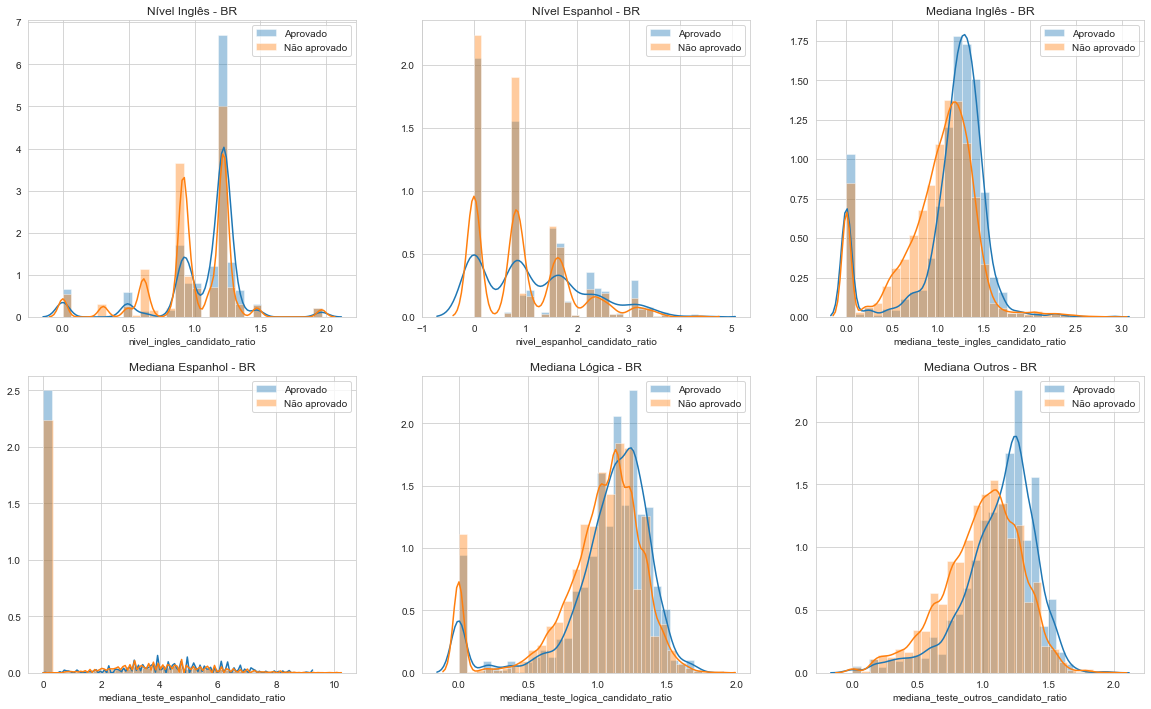

In [369]:
fig, ax = plt.subplots(2, 3, figsize=(20,12))

to_plot = ['nivel_ingles_candidato_ratio', 'nivel_espanhol_candidato_ratio', 'mediana_teste_ingles_candidato_ratio', 'mediana_teste_espanhol_candidato_ratio', 
            'mediana_teste_logica_candidato_ratio', 'mediana_teste_outros_candidato_ratio']

k = 0

for i in range(0,2):
    for j in range(0,3):
        try:
            sns.distplot(df_train_br.loc[df_train_br.aprovado_vaga == 1, to_plot[k]], ax = ax[i,j], bins = 30)
            sns.distplot(df_train_br.loc[df_train_br.aprovado_vaga == 0, to_plot[k]], ax = ax[i,j], bins = 30)
            ax[i,j].legend(['Aprovado', 'Não aprovado'])
            ax[i,j].set_title(f'{labels_plot[k]} - BR')
            
            k += 1
        except:
            continue

## Modelagem
### Vagas brasileiras
Vamos começar extraindo as features.

In [370]:
df_train_br.columns

Index(['codigo_vaga', 'ultimo_salario_candidato', 'ultimo_cargo_candidato',
       'area_interesse_candidato', 'nivel_candidato', 'formacao_candidato',
       'cidade_candidato', 'nivel_ingles_candidato',
       'nivel_espanhol_candidato', 'mediana_teste_ingles_candidato',
       'mediana_teste_espanhol_candidato', 'mediana_teste_logica_candidato',
       'mediana_teste_outros_candidato', 'formacao_vaga', 'cidade_vaga',
       'aprovado_vaga', 'igual_cidade', 'Uf_vaga', 'igual_uf', 'Nacionalidade',
       'is_new', 'salary_bin', 'ingles_bin', 'logica_bin', 'total_score',
       'grupo_interesse_Administracao', 'grupo_interesse_Arte',
       'grupo_interesse_Biologicas', 'grupo_interesse_Comunicacao',
       'grupo_interesse_Engenharia', 'grupo_interesse_Exatas',
       'grupo_interesse_Outro', 'grupo_interesse_Saude', 'Uf_candidato_AL',
       'Uf_candidato_AM', 'Uf_candidato_AP', 'Uf_candidato_BA',
       'Uf_candidato_CE', 'Uf_candidato_DF', 'Uf_candidato_ES',
       'Uf_candidato_GO

In [371]:
br_features = ['nivel_candidato', 'formacao_candidato', 'salary_bin', 'nivel_ingles_candidato_ratio','nivel_espanhol_candidato_ratio', 'mediana_teste_espanhol_candidato_ratio',
               'mediana_teste_ingles_candidato_ratio', 'mediana_teste_logica_candidato_ratio', 'nivel_ingles_candidato', 'mediana_teste_espanhol_candidato',
               'mediana_teste_ingles_candidato', 'mediana_teste_logica_candidato', 'mediana_teste_outros_candidato','mediana_teste_outros_candidato_ratio', 'total_score',
               'igual_cidade', 'igual_uf', 'Uf_candidato_AL', 'Uf_candidato_AM', 'Uf_candidato_BA', 'Uf_candidato_CE', 'Uf_candidato_DF', 'Uf_candidato_ES','Uf_candidato_GO', 
               'Uf_candidato_MA', 'Uf_candidato_MG', 'Uf_candidato_MS', 'Uf_candidato_MT', 'Uf_candidato_Nulo', 'Uf_candidato_PA', 'Uf_candidato_PB', 'Uf_candidato_PE',
               'Uf_candidato_PI', 'Uf_candidato_PR', 'Uf_candidato_RJ', 'Uf_candidato_RN', 'Uf_candidato_RO', 'Uf_candidato_RS', 'Uf_candidato_SC', 'Uf_candidato_SE', 
               'Uf_candidato_SP', 'Uf_candidato_TO']

x = df_train_br[br_features]
y = df_train_br['aprovado_vaga']

x.head()

,nivel_candidato,formacao_candidato,salary_bin,nivel_ingles_candidato_ratio,nivel_espanhol_candidato_ratio,mediana_teste_espanhol_candidato_ratio,mediana_teste_ingles_candidato_ratio,mediana_teste_logica_candidato_ratio,nivel_ingles_candidato,mediana_teste_espanhol_candidato,...,Uf_candidato_PI,Uf_candidato_PR,Uf_candidato_RJ,Uf_candidato_RN,Uf_candidato_RO,Uf_candidato_RS,Uf_candidato_SC,Uf_candidato_SE,Uf_candidato_SP,Uf_candidato_TO
0,2,6,0.0,0.608863,0.767636,0.000000,1.100183,1.041486,2.0,0.000,...,0,0,0,0,0,0,0,0,0,0
1,2,5,1.0,1.217726,0.767636,0.000000,1.364569,1.331436,4.0,0.000,...,0,0,0,0,0,0,0,0,1,0
2,1,5,2.0,0.608863,0.000000,0.000000,0.660963,0.888179,2.0,0.000,...,0,0,0,0,0,0,0,0,1,0
3,2,5,0.0,0.913294,0.000000,0.000000,1.236640,1.331436,3.0,0.000,...,0,0,0,0,0,0,0,0,1,0
4,3,6,2.0,0.913294,3.070544,5.052809,0.895498,1.108141,3.0,6.375,...,0,0,0,0,0,0,0,0,1,0


#### Validação
Para otimizar o processo de treino -> validação, vamos construir uma rotina eficaz que permita uma rápida verificação.

In [372]:
class Train_validate:
    def __init__(self, dic_models, train_ratio, x, y):
        self.models = dic_models
        self.train_ratio = train_ratio
        self.x = x
        self.y = y
    
    def fit(self):
        f1s = {}
        #Data
        scaler = StandardScaler()
        x = scaler.fit_transform(self.x)
        x_train, x_test, y_train, y_test = train_test_split(x, self.y, stratify = self.y, train_size = self.train_ratio, random_state = 0)
        ada = RandomOverSampler()
        x_ada, y_ada = ada.fit_resample(x_train, y_train)
        
        for model, label in zip(self.models.values(), self.models.keys()):
            print(f'Fitting Model {label}...\n')
            #fitting
            model.fit(x_ada, y_ada)
            predictions = model.predict(x_test)
            
            #metrics
            print(f'F1 Score: {f1_score(y_test, predictions)}')
            f1s[label] = f1_score(y_test, predictions)
            print(f'Confusion Matrix: \n')
            print(confusion_matrix(y_test, predictions))
            print(classification_report(y_test, predictions))
            skplt.metrics.plot_roc(y_test, model.predict_proba(x_test))
            plt.show()
        
        print("Resumo de F1's :")
        print(pd.DataFrame({'Modelo':list(f1s.keys()),
                           'F1':list(f1s.values())}).sort_values('F1', ascending = False))    

#### Problema a serem contornados
**Classes**  
Como já citado, a quantidade desproporcional de dados é um ponto crítico na modelagem. Existem algumas maneiras de amenizar esse efeito. Para fins de comparação, vamos executar um modelo que não possui nenhum tipo de tratamento no que diz respeito ao equilíbrio das classes.

In [373]:
model = RandomForestClassifier(random_state=0)
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify = y, train_size = 0.9, random_state = 0)
model.fit(x_train, y_train)
print(f'F1 Score: {f1_score(y_test, model.predict(x_test))}')
print(classification_report(y_test, model.predict(x_test)))

F1 Score: 0.020833333333333332
              precision    recall  f1-score   support

           0       0.92      0.99      0.95      2004
           1       0.14      0.01      0.02       178

    accuracy                           0.91      2182
   macro avg       0.53      0.50      0.49      2182
weighted avg       0.86      0.91      0.88      2182



Como observado, o modelo performa muito mal. Em termos gerais um F1 Score de ~0.04 não é um bom sinal, mas analisando recall e precision da classe 1 (Aprovados) fica evidente que o modelo possui muita dificuldade em reconhecer casos de aprovação (Recall extremamente baixo) e ainda por cima não possui uma acurácia muito satisfatória para os casos que ele encontra. Para resolver esse problema, diversas técnicas de **Oversampling**, **Undersampling**,**Criação de dados sintéticos** e **Class Weights** foram testados sendo o **Random Over Sampler** a técnica de oversampling mais efetiva. A aplicação do Random Over Sampler, assim como scaling dos atributos se encontra no método .fit() que criamos na classe "Train_validate"

#### Seleção de modelos

In [374]:
models = {
    'Logistic Regression': LogisticRegression(random_state=0),
    'Random Forest': RandomForestClassifier(max_depth = 10, n_estimators = 500, class_weight='balanced', random_state=0,min_samples_leaf = 30, min_samples_split = 30),
    'GradientBoostingClassifier': GradientBoostingClassifier(learning_rate = 0.01, n_estimators = 500, max_depth = 4, random_state= 0),
    'KNN': KNeighborsClassifier(n_neighbors= 15, weights='distance'),
    'HistGB': HistGradientBoostingClassifier(learning_rate = 0.03, max_iter = 200, max_leaf_nodes = 5, max_depth = 3, min_samples_leaf = 30, random_state= 0),
    'Bernoulli NB': BernoulliNB(),
    'LGBM': LGBMClassifier(max_depth= 4, num_leaves=15, class_weight='balanced', colsample_bytree=0.8, learning_rate= 0.03)
    }

train_validate = Train_validate(dic_models=models, train_ratio=0.9, x=x, y=y)

Fitting Model Logistic Regression...

F1 Score: 0.2490566037735849
Confusion Matrix: 

[[1254  750]
 [  46  132]]
              precision    recall  f1-score   support

           0       0.96      0.63      0.76      2004
           1       0.15      0.74      0.25       178

    accuracy                           0.64      2182
   macro avg       0.56      0.68      0.50      2182
weighted avg       0.90      0.64      0.72      2182



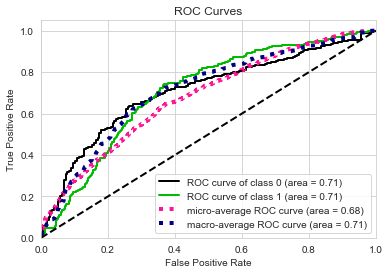

Fitting Model Random Forest...

F1 Score: 0.3063291139240506
Confusion Matrix: 

[[1513  491]
 [  57  121]]
              precision    recall  f1-score   support

           0       0.96      0.75      0.85      2004
           1       0.20      0.68      0.31       178

    accuracy                           0.75      2182
   macro avg       0.58      0.72      0.58      2182
weighted avg       0.90      0.75      0.80      2182



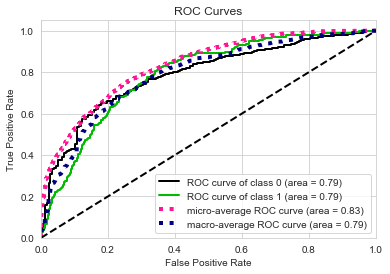

Fitting Model GradientBoostingClassifier...

F1 Score: 0.2962962962962963
Confusion Matrix: 

[[1400  604]
 [  42  136]]
              precision    recall  f1-score   support

           0       0.97      0.70      0.81      2004
           1       0.18      0.76      0.30       178

    accuracy                           0.70      2182
   macro avg       0.58      0.73      0.55      2182
weighted avg       0.91      0.70      0.77      2182



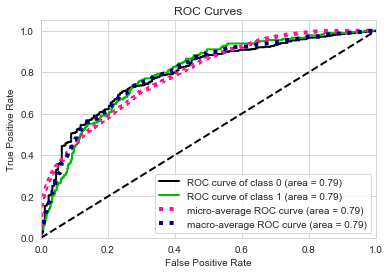

Fitting Model KNN...

F1 Score: 0.22222222222222227
Confusion Matrix: 

[[1358  646]
 [  75  103]]
              precision    recall  f1-score   support

           0       0.95      0.68      0.79      2004
           1       0.14      0.58      0.22       178

    accuracy                           0.67      2182
   macro avg       0.54      0.63      0.51      2182
weighted avg       0.88      0.67      0.74      2182



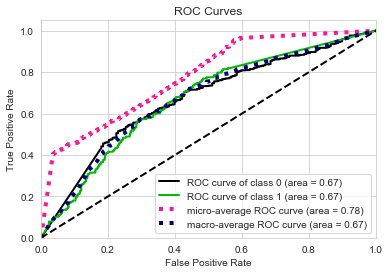

Fitting Model HistGB...

F1 Score: 0.2752475247524752
Confusion Matrix: 

[[1311  693]
 [  39  139]]
              precision    recall  f1-score   support

           0       0.97      0.65      0.78      2004
           1       0.17      0.78      0.28       178

    accuracy                           0.66      2182
   macro avg       0.57      0.72      0.53      2182
weighted avg       0.91      0.66      0.74      2182



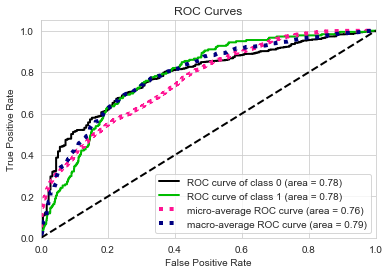

Fitting Model Bernoulli NB...

F1 Score: 0.23243243243243242
Confusion Matrix: 

[[1201  803]
 [  49  129]]
              precision    recall  f1-score   support

           0       0.96      0.60      0.74      2004
           1       0.14      0.72      0.23       178

    accuracy                           0.61      2182
   macro avg       0.55      0.66      0.49      2182
weighted avg       0.89      0.61      0.70      2182



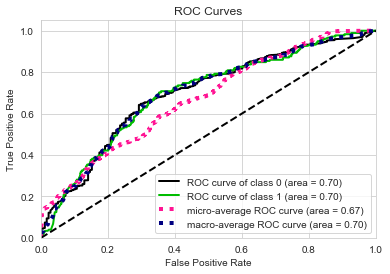

Fitting Model LGBM...

F1 Score: 0.2901554404145078
Confusion Matrix: 

[[1357  647]
 [  38  140]]
              precision    recall  f1-score   support

           0       0.97      0.68      0.80      2004
           1       0.18      0.79      0.29       178

    accuracy                           0.69      2182
   macro avg       0.58      0.73      0.54      2182
weighted avg       0.91      0.69      0.76      2182



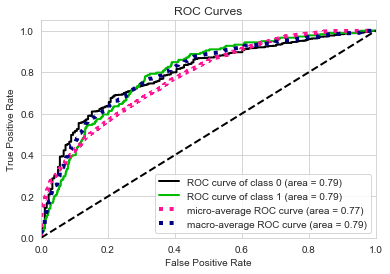

Resumo de F1's :
                       Modelo        F1
1               Random Forest  0.306329
2  GradientBoostingClassifier  0.296296
6                        LGBM  0.290155
4                      HistGB  0.275248
0         Logistic Regression  0.249057
5                Bernoulli NB  0.232432
3                         KNN  0.222222


In [375]:
train_validate.fit()

#### Otimização
Baseado na escolhe preliminar da seleção, iremos otimizar quatro modelos: HistGB, Random Forest, LGBM, GBClassifier.

In [454]:
#Data
scaler = StandardScaler()
ada = RandomOverSampler()
x = scaler.fit_transform(x)
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify = y, train_size = 0.9, random_state = 0)
x_ada, y_ada = ada.fit_resample(x_train, y_train)

**Random Forest**

In [390]:
def get_f1(params):
    
    max_depth = params[0]
    n_estimators = params[1]
    min_samples_leaf = params[2]
    min_samples_split = params[3]
    
    
    #RandomForestClassifier(max_depth = 10, n_estimators = 500, class_weight='balanced', random_state=0,min_samples_leaf = 30, min_samples_split = 30)
    model = RandomForestClassifier(max_depth = max_depth,
                                  n_estimators= n_estimators,
                                  class_weight='balanced',
                                  min_samples_leaf = min_samples_leaf,
                                  min_samples_split=min_samples_split,
                                  random_state=0)
    
    model.fit(x_ada, y_ada)
    predict = model.predict(x_test)
    
    return -f1_score(y_test, predict)

space = [(2, 15),
        (50, 1000),
        (2, 100),
        (2, 100)]

resultado = dummy_minimize(get_f1, space, random_state=0, verbose=0, n_calls=300)
print(resultado.x)
#[14, 343, 50, 84]

[15, 820, 5, 96]


**LGBM**

In [391]:
def get_f1(params):
    
    num_leaves = params[0]
    max_depth = params[1]
    learning_rate = params[2]
    n_estimators = params[3]
    subsample = params[4]
    colsample_bytree = params[5]
    reg_alpha = params[6]
    reg_lambda = params[7]
    
    
    #RandomForestClassifier(max_depth = 10, n_estimators = 500, class_weight='balanced', random_state=0,min_samples_leaf = 30, min_samples_split = 30)
    model = LGBMClassifier(num_leaves=num_leaves,
                          max_depth=max_depth,
                          learning_rate = learning_rate,
                          n_estimators = n_estimators,
                          subsample=subsample,
                          subsample_freq=1,
                          colsample_bytree = colsample_bytree,
                           reg_alpha = reg_alpha,
                           reg_lambda = reg_lambda,
                           random_state = 0
                          )
    
    model.fit(x_ada, y_ada)
    predict = model.predict(x_test)
    
    return -f1_score(y_test, predict)

space = [(2, 100),
        (2, 15),
        (1e-2, 1e-1),
        (2, 500),
        (0.5, 0.99),
        (0.5, 0.99),
        (0.01, 0.99),
        (0.01, 0.99)]

resultado = dummy_minimize(get_f1, space, random_state=0, verbose=0, n_calls=300)
print(resultado.x)
#[76, 10, 0.03220951629373303, 45, 0.6903180174128616, 0.7382733223013643, 0.5863884312265933, 0.9741767530879845]

[22, 13, 0.07124630330285435, 486, 0.9629066656392732, 0.9375025010139689, 0.6735721118365537, 0.6362468368017496]


**Gradient Boosting Classifier**

In [455]:
#Alterar n_scalls para otimização verdadeira
def get_f1(params):
    
    learning_rate = params[0]
    n_estimators = params[1]
    min_samples_split = params[2]
    min_samples_leaf = params[3]
    max_depth = params[4]
    
    
    
    #RandomForestClassifier(max_depth = 10, n_estimators = 500, class_weight='balanced', random_state=0,min_samples_leaf = 30, min_samples_split = 30)
    model = GradientBoostingClassifier(learning_rate=learning_rate, 
                                       n_estimators=n_estimators,
                                      min_samples_leaf=min_samples_leaf,
                                      min_samples_split=min_samples_split,
                                      max_depth=max_depth,
                                      random_state=0)
    
    model.fit(x_ada, y_ada)
    predict = model.predict(x_test)
    
    return -f1_score(y_test, predict)

space = [(1e-2,3e-1),
        (50, 300),
        (2,100),
        (2,100),
        (2,10)]

resultado = dummy_minimize(get_f1, space, random_state=0, verbose=0, n_calls=1)
print(resultado.x)
#[0.03879130160410243, 107, 37, 13, 4]

[0.18192493928525535, 242, 69, 69, 9]


**Histogram Gradient Boosting**

In [456]:
#Alterar n_calls para otimização verdadeira
def get_f1(params):
    
    learning_rate = params[0]
    max_iter = params[1]
    max_leaf_nodes = params[2]
    max_depth = params[3]
    min_samples_leaf = params[4]
    l2_reg = params[5]
    
    
    
    #0.017670975426506808, 145, 16, 8, 122, 0.9335723896472075
    #model = HistGradientBoostingClassifier(learning_rate = 0.03, max_iter = 200, max_leaf_nodes = 5, max_depth = 3, min_samples_leaf = 30)
    model = HistGradientBoostingClassifier(learning_rate=learning_rate,
                                       max_iter=max_iter,
                                       max_leaf_nodes=max_leaf_nodes,
                                       max_depth=max_depth,
                                       min_samples_leaf=min_samples_leaf,
                                       l2_regularization= l2_reg,
                                      random_state=0)
    
    model.fit(x_ada, y_ada)
    predict = model.predict(x_test)
    
    return -f1_score(y_test, predict)

space = [(0.01,0.03),
        (130, 200),
        (2,30),
        (5,15),
        (70,250),
        (0.6, 1)]

resultado = dummy_minimize(get_f1, space, random_state=0, verbose=0, n_calls=1)
print(resultado.x)
#[0.027422050666566562, 155, 9, 15, 232, 0.8318723570243853]

[0.021856892364500367, 194, 5, 8, 173, 0.7694619197355619]


**Modelos Otimizados**

In [395]:
rf = RandomForestClassifier(max_depth = 15,
                                  n_estimators= 820,
                                  class_weight='balanced',
                                  min_samples_leaf = 5,
                                  min_samples_split=96,
                                  random_state=0)

lgbm = LGBMClassifier(num_leaves=22,
                          max_depth=13,
                          learning_rate = 0.07124630330285435,
                          n_estimators = 486,
                          subsample=0.9629066656392732,
                          subsample_freq=1,
                          colsample_bytree = 0.9375025010139689,
                           reg_alpha = 0.6735721118365537,
                           reg_lambda = 0.6362468368017496,
                           random_state = 0
                          )


gbc = GradientBoostingClassifier(learning_rate=0.1328598918082824, 
                                       n_estimators=71,
                                      min_samples_leaf=38,
                                      min_samples_split=89,
                                      max_depth=8,
                                      random_state=0)


hgbc = HistGradientBoostingClassifier(learning_rate=0.024170963000400062,
                                       max_iter=184,
                                       max_leaf_nodes=27,
                                       max_depth=9,
                                       min_samples_leaf=167,
                                       l2_regularization= 0.6777368891771933,
                                      random_state=0)
    

**Stacking Classifier**

In [ ]:
stack = StackingClassifier(classifiers=[rf, lgbm, gbc, hgbc], 
                          meta_classifier=hgbc,
                          
                        )
                          #average_probas=False)

stack.fit(x_ada, y_ada)
print(f1_score(y_test, stack.predict(x_test)))
print(classification_report(y_test, stack.predict(x_test)))

In [396]:
print('Começando fit...')
rf.fit(x_ada,y_ada)
lgbm.fit(x_ada, y_ada)
gbc.fit(x_ada, y_ada)
hgbc.fit(x_ada, y_ada)

#Teste
predictions = (rf.predict_proba(x_test)[:,1] + lgbm.predict_proba(x_test)[:,1] + gbc.predict_proba(x_test)[:,1] + hgbc.predict_proba(x_test)[:,1]) / 4
predictions = [1 if x > 0.47 else 0 for x in predictions]
predictions

print(f1_score(y_test, predictions))
print(classification_report(y_test, predictions))

0.3519061583577713
              precision    recall  f1-score   support

           0       0.97      0.81      0.88      2004
           1       0.24      0.67      0.35       178

    accuracy                           0.80      2182
   macro avg       0.60      0.74      0.62      2182
weighted avg       0.91      0.80      0.84      2182



### Vagas Estrangeiras
A abordagem para essas vagas será um pouco diferente, isso se da pelo fato de que os dados de vagas estrangeiras possuem uma elevada quantidade de valores zerados.
Em um primeiro momento precisamos aderessar algumas coisas:
 - A lógica aplicada utilizando UF's não funcionará nesse caso.
 - Não utilizar dados salariais

In [398]:
es_features = ['nivel_candidato','formacao_candidato', 'nivel_ingles_candidato', 'nivel_espanhol_candidato', 'mediana_teste_ingles_candidato', 'mediana_teste_espanhol_candidato',
              'mediana_teste_logica_candidato', 'mediana_teste_outros_candidato', 'formacao_vaga', 'igual_cidade','grupo_interesse_Administracao', 'grupo_interesse_Arte',
               'grupo_interesse_Biologicas', 'grupo_interesse_Comunicacao', 'grupo_interesse_Engenharia', 'grupo_interesse_Exatas','grupo_interesse_Outro', 'grupo_interesse_Saude',
               'nivel_ingles_candidato_ratio', 'nivel_espanhol_candidato_ratio', 'mediana_teste_ingles_candidato_ratio', 'mediana_teste_espanhol_candidato_ratio', 
               'mediana_teste_logica_candidato_ratio', 'mediana_teste_outros_candidato_ratio', 'is_qualified', 'has_language', 'total_score'
              ]

x_es = df_train_es[es_features]
y_es = df_train_es['aprovado_vaga']

x_es.head()

,nivel_candidato,formacao_candidato,nivel_ingles_candidato,nivel_espanhol_candidato,mediana_teste_ingles_candidato,mediana_teste_espanhol_candidato,mediana_teste_logica_candidato,mediana_teste_outros_candidato,formacao_vaga,igual_cidade,...,grupo_interesse_Saude,nivel_ingles_candidato_ratio,nivel_espanhol_candidato_ratio,mediana_teste_ingles_candidato_ratio,mediana_teste_espanhol_candidato_ratio,mediana_teste_logica_candidato_ratio,mediana_teste_outros_candidato_ratio,is_qualified,has_language,total_score
15727,3,5,0.0,0.0,0.0,0.0,0.0,4.7,0,0,...,0,0.0,0.0,0.0,0.0,0.0,0.882253,1,0,1.175
15728,5,5,0.0,0.0,0.0,0.0,0.0,7.2,0,0,...,0,0.0,0.0,0.0,0.0,0.0,1.351536,1,0,1.800
15729,1,5,0.0,0.0,0.0,0.0,0.0,6.4,0,0,...,0,0.0,0.0,0.0,0.0,0.0,1.201365,1,0,1.600
15730,1,4,0.0,0.0,0.0,0.0,0.0,5.6,0,0,...,0,0.0,0.0,0.0,0.0,0.0,1.051195,1,0,1.400
15731,1,6,0.0,0.0,0.0,0.0,0.0,3.9,0,0,...,0,0.0,0.0,0.0,0.0,0.0,0.732082,1,0,0.975


**Modelo Baseline**  
É um exemplo similar ao utilizado nos dados brasileiros para ilustrar o impacto da falta de tratamento das classes. Queremos saber como nossos dados performam sem aplicar nenhum tipo de transformação adicional a eles.

In [399]:
model = RandomForestClassifier(random_state=0)
x_train, x_test, y_train, y_test = train_test_split(x_es, y_es, stratify = y_es, train_size = 0.9, random_state = 0)
model.fit(x_train, y_train)
print(f'F1 Score: {f1_score(y_test, model.predict(x_test))}')
print(classification_report(y_test, model.predict(x_test)))

F1 Score: 0.1869158878504673
              precision    recall  f1-score   support

           0       0.82      0.93      0.87       315
           1       0.30      0.14      0.19        74

    accuracy                           0.78       389
   macro avg       0.56      0.53      0.53       389
weighted avg       0.72      0.78      0.74       389



Wow, uma grata surpresa! Os dados estrangeiros performaram muito melhor do que o baseline brasileiro.

**Validação**

In [400]:
models = {
    'Logistic Regression': LogisticRegression(random_state=0),
    'Random Forest': RandomForestClassifier(max_depth = 10, n_estimators = 500, class_weight='balanced', random_state=0,min_samples_leaf = 30, min_samples_split = 30),
    'GradientBoostingClassifier': GradientBoostingClassifier(learning_rate = 0.01, n_estimators = 500, max_depth = 4, random_state= 0),
    'KNN': KNeighborsClassifier(n_neighbors= 15, weights='distance'),
    'HistGB': HistGradientBoostingClassifier(learning_rate = 0.03, max_iter = 200, max_leaf_nodes = 5, max_depth = 3, min_samples_leaf = 30, random_state= 0),
    'Bernoulli NB': BernoulliNB(),
    'LGBM': LGBMClassifier(max_depth= 4, num_leaves=15, class_weight='balanced', colsample_bytree=0.8, learning_rate= 0.03)
    }

train_validate = Train_validate(dic_models=models, train_ratio=0.9, x=x_es, y=y_es)

Fitting Model Logistic Regression...

F1 Score: 0.4055299539170507
Confusion Matrix: 

[[216  99]
 [ 30  44]]
              precision    recall  f1-score   support

           0       0.88      0.69      0.77       315
           1       0.31      0.59      0.41        74

    accuracy                           0.67       389
   macro avg       0.59      0.64      0.59       389
weighted avg       0.77      0.67      0.70       389



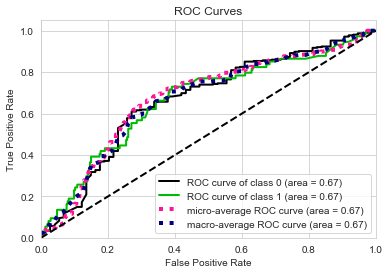

Fitting Model Random Forest...

F1 Score: 0.4340425531914894
Confusion Matrix: 

[[205 110]
 [ 23  51]]
              precision    recall  f1-score   support

           0       0.90      0.65      0.76       315
           1       0.32      0.69      0.43        74

    accuracy                           0.66       389
   macro avg       0.61      0.67      0.59       389
weighted avg       0.79      0.66      0.69       389



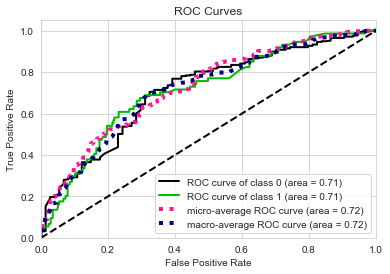

Fitting Model GradientBoostingClassifier...

F1 Score: 0.4214876033057851
Confusion Matrix: 

[[198 117]
 [ 23  51]]
              precision    recall  f1-score   support

           0       0.90      0.63      0.74       315
           1       0.30      0.69      0.42        74

    accuracy                           0.64       389
   macro avg       0.60      0.66      0.58       389
weighted avg       0.78      0.64      0.68       389



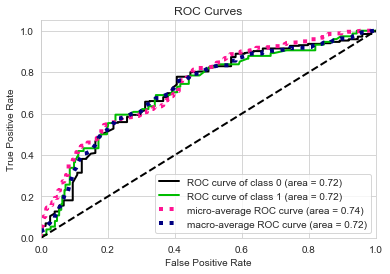

Fitting Model KNN...

F1 Score: 0.36666666666666664
Confusion Matrix: 

[[242  73]
 [ 41  33]]
              precision    recall  f1-score   support

           0       0.86      0.77      0.81       315
           1       0.31      0.45      0.37        74

    accuracy                           0.71       389
   macro avg       0.58      0.61      0.59       389
weighted avg       0.75      0.71      0.73       389



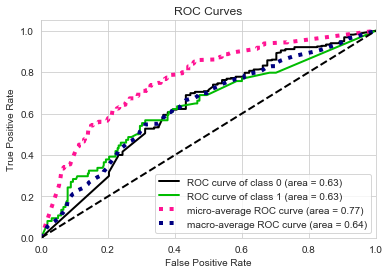

Fitting Model HistGB...

F1 Score: 0.4251968503937008
Confusion Matrix: 

[[189 126]
 [ 20  54]]
              precision    recall  f1-score   support

           0       0.90      0.60      0.72       315
           1       0.30      0.73      0.43        74

    accuracy                           0.62       389
   macro avg       0.60      0.66      0.57       389
weighted avg       0.79      0.62      0.67       389



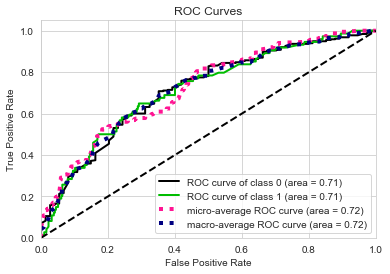

Fitting Model Bernoulli NB...

F1 Score: 0.4094488188976378
Confusion Matrix: 

[[187 128]
 [ 22  52]]
              precision    recall  f1-score   support

           0       0.89      0.59      0.71       315
           1       0.29      0.70      0.41        74

    accuracy                           0.61       389
   macro avg       0.59      0.65      0.56       389
weighted avg       0.78      0.61      0.66       389



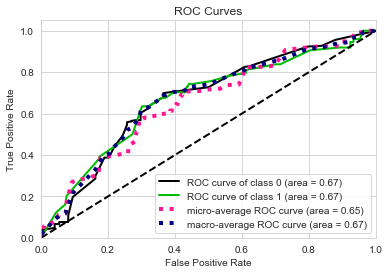

Fitting Model LGBM...

F1 Score: 0.41245136186770426
Confusion Matrix: 

[[185 130]
 [ 21  53]]
              precision    recall  f1-score   support

           0       0.90      0.59      0.71       315
           1       0.29      0.72      0.41        74

    accuracy                           0.61       389
   macro avg       0.59      0.65      0.56       389
weighted avg       0.78      0.61      0.65       389



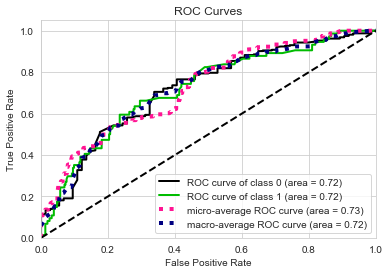

Resumo de F1's :
                       Modelo        F1
1               Random Forest  0.434043
4                      HistGB  0.425197
2  GradientBoostingClassifier  0.421488
6                        LGBM  0.412451
5                Bernoulli NB  0.409449
0         Logistic Regression  0.405530
3                         KNN  0.366667


In [401]:
train_validate.fit()

**Otimização**

In [402]:
#Data
scaler = StandardScaler()
ada = RandomOverSampler()
x = scaler.fit_transform(x)
x_train, x_test, y_train, y_test = train_test_split(x_es, y_es, stratify = y_es, train_size = 0.9, random_state = 0)
x_ada, y_ada = ada.fit_resample(x_train, y_train)

**Random Forest**

In [403]:
def get_f1(params):
    
    max_depth = params[0]
    n_estimators = params[1]
    min_samples_leaf = params[2]
    min_samples_split = params[3]
    
    
    #RandomForestClassifier(max_depth = 10, n_estimators = 500, class_weight='balanced', random_state=0,min_samples_leaf = 30, min_samples_split = 30)
    model = RandomForestClassifier(max_depth = max_depth,
                                  n_estimators= n_estimators,
                                  class_weight='balanced',
                                  min_samples_leaf = min_samples_leaf,
                                  min_samples_split=min_samples_split,
                                  random_state=0)
    
    model.fit(x_ada, y_ada)
    predict = model.predict(x_test)
    
    return -f1_score(y_test, predict)

space = [(2, 15),
        (50, 1000),
        (2, 100),
        (2, 100)]

resultado = dummy_minimize(get_f1, space, random_state=0, verbose=0, n_calls=300)
print(resultado.x)
#[14, 343, 50, 84]

[12, 463, 4, 7]


**LGBM**

In [404]:
def get_f1(params):
    
    num_leaves = params[0]
    max_depth = params[1]
    learning_rate = params[2]
    n_estimators = params[3]
    subsample = params[4]
    colsample_bytree = params[5]
    reg_alpha = params[6]
    reg_lambda = params[7]
    
    
    #RandomForestClassifier(max_depth = 10, n_estimators = 500, class_weight='balanced', random_state=0,min_samples_leaf = 30, min_samples_split = 30)
    model = LGBMClassifier(num_leaves=num_leaves,
                          max_depth=max_depth,
                          learning_rate = learning_rate,
                          n_estimators = n_estimators,
                          subsample=subsample,
                          subsample_freq=1,
                          colsample_bytree = colsample_bytree,
                           reg_alpha = reg_alpha,
                           reg_lambda = reg_lambda,
                           random_state = 0
                          )
    
    model.fit(x_ada, y_ada)
    predict = model.predict(x_test)
    
    return -f1_score(y_test, predict)

space = [(2, 100),
        (2, 15),
        (1e-2, 1e-1),
        (2, 500),
        (0.5, 0.99),
        (0.5, 0.99),
        (0.01, 0.99),
        (0.01, 0.99)]

resultado = dummy_minimize(get_f1, space, random_state=0, verbose=0, n_calls=300)
print(resultado.x)
#[76, 10, 0.03220951629373303, 45, 0.6903180174128616, 0.7382733223013643, 0.5863884312265933, 0.9741767530879845]

[36, 2, 0.07801641831492773, 279, 0.7830191441212409, 0.5368858671180399, 0.08668117769665944, 0.37386120539684936]


**Gradient Boosting Classifier**

In [405]:
def get_f1(params):
    
    learning_rate = params[0]
    n_estimators = params[1]
    min_samples_split = params[2]
    min_samples_leaf = params[3]
    max_depth = params[4]
    
    
    
    #RandomForestClassifier(max_depth = 10, n_estimators = 500, class_weight='balanced', random_state=0,min_samples_leaf = 30, min_samples_split = 30)
    model = GradientBoostingClassifier(learning_rate=learning_rate, 
                                       n_estimators=n_estimators,
                                      min_samples_leaf=min_samples_leaf,
                                      min_samples_split=min_samples_split,
                                      max_depth=max_depth,
                                      random_state=0)
    
    model.fit(x_ada, y_ada)
    predict = model.predict(x_test)
    
    return -f1_score(y_test, predict)

space = [(1e-2,3e-1),
        (50, 300),
        (2,100),
        (2,100),
        (2,10)]

resultado = dummy_minimize(get_f1, space, random_state=0, verbose=0, n_calls=100)
print(resultado.x)
#[0.03879130160410243, 107, 37, 13, 4]

[0.03231736962612349, 137, 98, 85, 2]


**Histogram Gradient Boosting Classifier**

In [406]:
def get_f1(params):
    
    learning_rate = params[0]
    max_iter = params[1]
    max_leaf_nodes = params[2]
    max_depth = params[3]
    min_samples_leaf = params[4]
    l2_reg = params[5]
    
    
    
    #0.017670975426506808, 145, 16, 8, 122, 0.9335723896472075
    #model = HistGradientBoostingClassifier(learning_rate = 0.03, max_iter = 200, max_leaf_nodes = 5, max_depth = 3, min_samples_leaf = 30)
    model = HistGradientBoostingClassifier(learning_rate=learning_rate,
                                       max_iter=max_iter,
                                       max_leaf_nodes=max_leaf_nodes,
                                       max_depth=max_depth,
                                       min_samples_leaf=min_samples_leaf,
                                       l2_regularization= l2_reg,
                                      random_state=0)
    
    model.fit(x_ada, y_ada)
    predict = model.predict(x_test)
    
    return -f1_score(y_test, predict)

space = [(0.01,0.03),
        (130, 200),
        (2,30),
        (5,15),
        (70,250),
        (0.6, 1)]

resultado = dummy_minimize(get_f1, space, random_state=0, verbose=0, n_calls=300)
print(resultado.x)
#[0.027422050666566562, 155, 9, 15, 232, 0.8318723570243853]

[0.02957236684465528, 179, 21, 8, 217, 0.6473097703475733]


**Modelos Otimizados**:

In [407]:
rf_es = RandomForestClassifier(max_depth = 12,
                                  n_estimators= 463,
                                  class_weight='balanced',
                                  min_samples_leaf = 4,
                                  min_samples_split=7,
                                  random_state=0)

lgbm_es = LGBMClassifier(num_leaves=36,
                          max_depth=2,
                          learning_rate = 0.07801641831492773,
                          n_estimators = 279,
                          subsample=0.7830191441212409,
                          subsample_freq=1,
                          colsample_bytree = 0.5368858671180399,
                           reg_alpha = 0.08668117769665944,
                           reg_lambda =0.37386120539684936,
                           random_state = 0
                          )

gbc_es = GradientBoostingClassifier(learning_rate=0.03231736962612349, 
                                       n_estimators=137,
                                      min_samples_leaf=98,
                                      min_samples_split=85,
                                      max_depth=2,
                                      random_state=0)

hgbc_es = HistGradientBoostingClassifier(learning_rate=0.02957236684465528,
                                       max_iter=179,
                                       max_leaf_nodes=21,
                                       max_depth=8,
                                       min_samples_leaf=217,
                                       l2_regularization= 0.6473097703475733,
                                      random_state=0)

In [408]:
rf_es.fit(x_ada,y_ada)
lgbm_es.fit(x_ada, y_ada)
gbc_es.fit(x_ada, y_ada)
hgbc_es.fit(x_ada, y_ada)

#Teste
predictions = (rf_es.predict_proba(x_test)[:,1] + lgbm_es.predict_proba(x_test)[:,1] + gbc_es.predict_proba(x_test)[:,1] + hgbc_es.predict_proba(x_test)[:,1]) / 4
predictions = [1 if x > 0.5 else 0 for x in predictions]
predictions

print(f1_score(y_test, predictions))
print(classification_report(y_test, predictions))

0.4435146443514644
              precision    recall  f1-score   support

           0       0.91      0.64      0.75       315
           1       0.32      0.72      0.44        74

    accuracy                           0.66       389
   macro avg       0.61      0.68      0.60       389
weighted avg       0.79      0.66      0.69       389



## Predição Final
Agora basicamente é prever os dois "pedaços" que mantivemos até aqui: Dados Brasileiros e Dados Estrangeiros.

In [431]:
#Funções de stacking
def stack_br(df):
    predictions = (rf.predict_proba(df)[:,1] + lgbm.predict_proba(df)[:,1] + gbc.predict_proba(df)[:,1] + hgbc.predict_proba(df)[:,1]) / 4
    predictions = [1 if x > 0.5 else 0 for x in predictions]
    return predictions

def stack_es(df):
    predictions = (rf_es.predict_proba(df)[:,1] + lgbm_es.predict_proba(df)[:,1] + gbc_es.predict_proba(df)[:,1] + hgbc_es.predict_proba(df)[:,1]) / 4
    predictions = [1 if x > 0.5 else 0 for x in predictions]
    return predictions

#Treinando com dados completos
sampler = RandomOverSampler()
## BR
#Dados
x_br = df_train_br[br_features]
y_br = df_train_br['aprovado_vaga']

x_br = scaler.fit_transform(x_br)
x_br, y_br =  sampler.fit_resample(x_br, y_br)
#Fit
rf.fit(x_br, y_br)
lgbm.fit(x_br, y_br)
gbc.fit(x_br, y_br)
hgbc.fit(x_br, y_br)

## ES
#Dados
x_es = df_train_es[es_features]
y_es = df_train_es['aprovado_vaga']

x_es = scaler.fit_transform(x_es)
x_es, y_es =  sampler.fit_resample(x_es, y_es)

#Fit
rf_es.fit(x_es, y_es)
lgbm_es.fit(x_es, y_es)
gbc_es.fit(x_es, y_es)
hgbc_es.fit(x_es, y_es)


HistGradientBoostingClassifier(l2_regularization=0.6473097703475733,
                               learning_rate=0.02957236684465528, loss='auto',
                               max_bins=256, max_depth=8, max_iter=179,
                               max_leaf_nodes=21, min_samples_leaf=217,
                               n_iter_no_change=None, random_state=0,
                               scoring=None, tol=1e-07, validation_fraction=0.1,
                               verbose=0)

**Vagas Brasileiras**

In [432]:
#Dados
x_topredict = df_test_br[br_features]
x_topredict = scaler.fit_transform(x_topredict)

br_predict = stack_br(x_topredict)

**Vagas Estrangeiras**

In [433]:
#Dados
x_topredict_es = df_test_es[es_features]
x_topredict_es = scaler.fit_transform(x_topredict_es)

es_predict = stack_es(x_topredict_es)

**Juntando resultados**

In [434]:
result = pd.DataFrame({'ID': df_test_br.ID,
                      'pred': br_predict})

result = pd.concat([result, pd.DataFrame({'ID': df_test_es.ID,
                                         'pred': es_predict})]).sort_values('ID')


result.drop('ID', axis = 1, inplace = True)

result.to_pickle('result.pkl')



<p style='font-size: 30px; text-align:center; margin-bottom:0px;'><b>ACABOU!</b></p>
<p style = 'text-align: center;'>Quer dizer, quase.</p>
<img src="https://media.giphy.com/media/QLvRBqfLXCphu/source.gif"/>
<p style = 'text-align: center; font-size: 12px;'>Minha reação ao perceber que as 5 features que inseri não quebraram o modelo.</p>






<p style='font-size: 30px; text-align:center; margin-bottom:0px;'><b>Reflexões e testes</b></p>
<p style = 'text-align: center;'>Essa parte do notebook não tem qualquer impacto na modelagem/resposta final do desafio. Esse notebook contém apenas as escolhas finais, ou seja, ele acaba não retratando algumas descobertas interessantes e também fracassos interessantes (Apesar de serem fracassos, foram um ótimo aprendizado). Esse espaço apenas serve para compartilhar um pouco da minha visão sobre o desafio, como demonstrar idéias que pareciam ótimas no papel e péssimas na prática.</p>






<p style='font-size: 15px; text-align:center; margin-bottom:0px;'><b>Resultados</b></p>
<p style = 'text-align: center;'>Você pode me perguntar: "Lucas, você ficou satisfeito com o resultado?" e eu te responderei que depende. Confesso que foi um pouco frustrante não conseguir passar a barreira de 0.35~0.4 durante minhas validações e o número de maneira absoluta não me agrada em nada, porém, pode existir uma série de motivos para esse resultado.A minha abordagem pode estar errada? Sem dúvidas. Os dados podem ter sido um fator limitante? Sem dúvidas. A minha validação não foi executada de maneira apropriada? Sem dúvidas. Posso ter deixado passar algum insight precioso que elevaria a performance do modelo? Você ja sabe a resposta. A questão é que em determinado momento no processo de desenvolvimento eu deixei de me preocupar com a métrica e passei a me preocupar com o quão bem o modelo era capaz de resolver o problema proposto, em determinado ponto me conformei de que não iria conseguir bater 0.4, 0.5 ou quem sabe 0.8 na métrica F1 para a classe de aprovados e isso fez eu me sentir péssimo. </p>
<img src='https://media.giphy.com/media/3o7WTqo27pLRYxRtg4/source.gif'>
<p style = 'text-align: center; font-size: 12px;'>Seria eu a vergonha da profissón?</p>
<p style = 'text-align: center;'>F1 Score é uma métrica que consolida em um único número o recall e a precision de um modelo, minhas primeiras abordagens obtinham números baixos para precision e recall (F1 score de ~0.19) e conforme esse número ia aumentando passei a perceber que dependendo do algoritmo empregado a precision subia pouco (cerca de 10%) mas tinha como custo uma perca grande no recall. Agora você pode me perguntar: O que você priorizaria? depende (mestre dos magos mesmo) e para ilustrar o motivo disso vou dar um pequeno exemplo. </p>
<img src='images/creport1.png'>
<p style = 'text-align: center;'>Esse é o classification report da stacking de modelos que utilizamos para os dados brasileiros. Imagine uma situação em que entre 10000 candidatos temos 1000 candidatos que são perfeitos para a vaga e sem dúvida seriam aprovados, o modelo nesse cenário consegue capturar 670 candidatos dos 1000 que são perfeitos para a vaga, porém, entre os candidatos que o modelo classifica como possíveis aprovações apenas 1 entre 4 (~25%) são de fato bons candidatos. Nesse cenário é importante notar o que cada métrica otimiza, um <b>Recall elevado</b> significa que você vai conseguir captar o máximo de ótimos candidatos para essa vaga, enquanto um <b>Precision elevado</b> significa menos tempo perdido em entrevistas com candidatos que não são ótimos para aquela vaga. É fundamental manter um equilíbrio entre recall e precision, e na minha opinião o modelo acima possui um custo-benefício muito melhor do que o modelo demonstrado abaixo (Considerando apenas a classe 1). </p>
<img src='images/creport2.png'>






<p style='font-size: 15px; text-align:center; margin-bottom:0px;'><b>Cada vaga é um universo</b></p>
<p style = 'text-align: center;'>Ficou evidente durante o desenvolvimento do modelo que eu optei por separar na modelagem vagas que possuiam a grande maioria de candidatos brasileiros, e aquelas que possuiam a grande maioria de candidatos estrangeiros. Porém, um processo de contratação é muito complexo e mesmo dentro das vagas brasileiras não existe um comportamento padrão entre as vagas, e a melhor forma de provar isso é mostrando métricas. Observe como para cada vaga existe um algoritmo que se comporta melhor do que o outro.</p>





In [449]:
processos = df_train_br.groupby('codigo_vaga').count().index

for processo in processos:
    data = df_train_br.loc[df_train_br.codigo_vaga == processo, br_features]
    data = scaler.fit_transform(data)
    
    target = df_train_br.loc[df_train_br.codigo_vaga == processo, 'aprovado_vaga']
    x_train, x_test, y_train, y_test = train_test_split(data,target, train_size = 0.9, random_state = 0)
    
    sampler = RandomOverSampler()
    x_train, y_train = sampler.fit_resample(x_train, y_train)
    
    model = LGBMClassifier()
    model2 = LogisticRegression()
    model.fit(x_train, y_train)
    model2.fit(x_train, y_train)
    
    print(f'F1 Regressão Logística {processo}: {f1_score(y_test, model2.predict(x_test))}')
    print(f'F1 LGBM {processo}: {f1_score(y_test, model.predict(x_test))}\n')
    

F1 Regressão Logística -8665149857608157082: 0.4
F1 LGBM -8665149857608157082: 0.4444444444444445

F1 Regressão Logística -8121008623955203509: 0.2222222222222222
F1 LGBM -8121008623955203509: 0.0

F1 Regressão Logística -7433230746669201352: 0.09523809523809523
F1 LGBM -7433230746669201352: 0.0

F1 Regressão Logística -5433147389500583028: 0.1894736842105263
F1 LGBM -5433147389500583028: 0.21052631578947367

F1 Regressão Logística -4680893303693323076: 0.3089430894308943
F1 LGBM -4680893303693323076: 0.3875968992248062

F1 Regressão Logística -3218332895185976716: 0.4
F1 LGBM -3218332895185976716: 0.3

F1 Regressão Logística -3139734604785841859: 0.2380952380952381
F1 LGBM -3139734604785841859: 0.0

F1 Regressão Logística -328337796252815598: 0.5454545454545455
F1 LGBM -328337796252815598: 0.4210526315789473

F1 Regressão Logística 3432259187290165962: 0.3783783783783784
F1 LGBM 3432259187290165962: 0.0

F1 Regressão Logística 3773628003473435874: 0.4
F1 LGBM 3773628003473435874: 0.43

<p style = 'text-align: center;'>É possível notar que os scores F1 variam bastante quando analisamos cada vaga individualmente e acabam variando entre modelos dentro da própria vaga, e talvez você esteja se perguntando se vale a pena descartar os dados que performam muito mal individualmente e a resposta é não, pois acabamos perdendo informações de candidatos que passaram (Tentei de tudo, desde selecionar aleatoriamente um numero n de vagas para treinamento e n-1 restantes para teste, treinar apenas com a vaga de código -7433230746669201352 e testar em outras e o resultado não foi satisfatório para esses cenários). Porém essa situação me fez pensar em algo: e se fosse possível otimizar o treinamento e predição de cada vaga de teste baseado em sua similaridade com a de treino? Era sexta-feira a noite, e eu estava muito motivado. </p>
<img src = 'https://media.giphy.com/media/CpgNjk2E54p7W/source.gif'>
<p style = 'text-align: center;'>A idéia que eu tive fugia totalmente ao procedimento padrão dos meus processo de análises e eu me sentia como um cientista do mal planejando seu plano para conquistar o mundo com um plano extremamente mirabolante e lindo, pelo menos no papel. </p>
<img src='images/diagram2.png'>
<p style = 'text-align: center;'>O processo consiste em basicamente identificar através do vizinho mais próximo qual vaga de treino mais se assemelha a uma vaga de teste, em seguida escolher qual algoritmo melhor se comporta para este conjunto de dados e utilizar esse mesmo algortimo para predizer a vaga de teste. <b>Funcionou?</b> Não. As vagas pareadas pelo Nearest Neighbors não eram tão identicas assim e em nosso conjunto de dados uma pequena variação ja é suficiente para gerar viés na modelagem, mas não deixa de ser um plano ousado, eu diria.  </p>



<p style='font-size: 30px; text-align:center; margin-bottom:0px;'><b>Obrigado!</b></p>
<img src="https://media.giphy.com/media/l0Iyh14JXlq9soEXS/source.gif"/>
<p style = 'text-align: center;'>Obrigado por acompanhar até aqui, sem dúvidas esse desafio foi uma ótima fonte de aprendizado e espero que você tenha aproveitado essa jornada ao meu lado pelo mundo das candidaturas online.</p>


